<a href="https://colab.research.google.com/github/c-mmonteiro/t1-algo-feature/blob/main/Transformers_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicação de LSTM e Transformers para ações

Carlos Monteiro


In [1]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi



from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter

import yfinance as yf
from datetime import datetime, timedelta


# 1. Preparação dos dados

## 1.1 Gerar Dados

In [2]:

ticker = "PETR4.SA"
end_date = datetime.today()
start_date = end_date - timedelta(days=20*365)


df = yf.download(
    ticker,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval="1d",
    auto_adjust=False,   # Mantém OHLC originais
    progress=False
)

df


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2006-01-09,4.027727,20.420000,20.650000,20.180000,20.344999,8782200
2006-01-10,4.034630,20.455000,20.625000,20.225000,20.455000,13541600
2006-01-11,4.171715,21.150000,21.225000,20.605000,20.625000,15117800
2006-01-12,4.206234,21.325001,21.795000,20.950001,21.145000,16237800
2006-01-13,4.201303,21.299999,21.620001,21.080000,21.424999,7932600
...,...,...,...,...,...,...
2025-12-23,30.309999,30.309999,30.570000,30.200001,30.549999,35703900
2025-12-26,30.410000,30.410000,30.430000,30.120001,30.309999,20178600


In [3]:
df.columns = [col[0] for col in df.columns]
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [4]:
df = df.drop(columns=['Adj Close'])

In [5]:
df['y'] = (df['Close'].diff(periods=-1))*-1
display(df.head())

,Close,High,Low,Open,Volume,y
Date,,,,,,
2006-01-09,20.420000,20.650000,20.180000,20.344999,8782200,0.035000
2006-01-10,20.455000,20.625000,20.225000,20.455000,13541600,0.695000
2006-01-11,21.150000,21.225000,20.605000,20.625000,15117800,0.175001
2006-01-12,21.325001,21.795000,20.950001,21.145000,16237800,-0.025002
2006-01-13,21.299999,21.620001,21.080000,21.424999,7932600,0.425001


In [6]:
print(df.isnull().sum())
df.dropna(inplace=True)

Close     0
High      0
Low       0
Open      0
Volume    0
y         1
dtype: int64


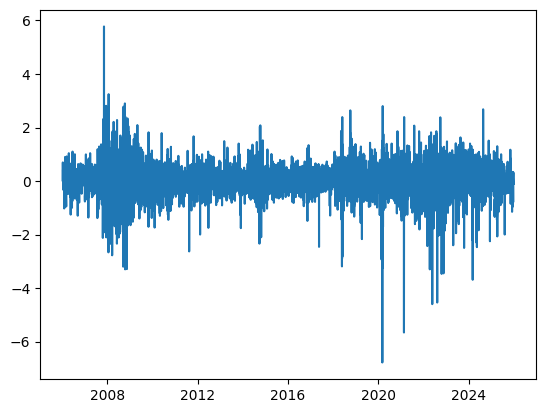

In [7]:
plt.plot(df['y'])

## 1.5 Scaling and Deframing

Features shape: (1, 4969, 5), Targets shape: (1, 4969, 1)


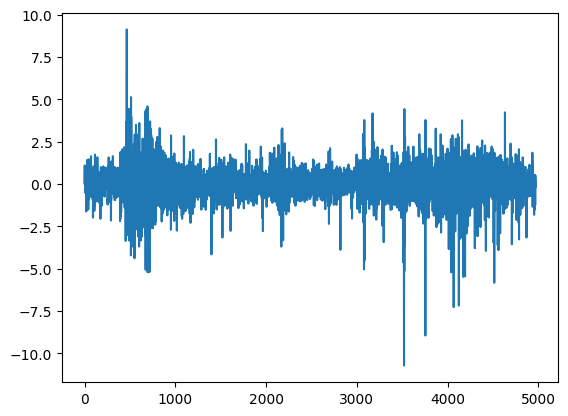

In [11]:
columns_atributo = [col for col in df.columns if not col.startswith('y')]
n_feat = len(columns_atributo)
n_samples = len(df)

X = df[columns_atributo].values.astype(np.float32).reshape(1, -1, n_feat)

y = df['y'].values.astype(np.float32).reshape(1, -1, 1)


# STANDARDIZATION: critical for training stability
# Why? Large/varying scales → unstable gradients, slow convergence
X_mean = X.mean(axis=(0,1), keepdims=True)  # Mean over all samples and timesteps
X_std  = X.std(axis=(0,1), keepdims=True) + 1e-6  # +epsilon to avoid division by zero
y_mean = y.mean(axis=(0,1), keepdims=True)
y_std  = y.std(axis=(0,1), keepdims=True) + 1e-6

X = (X - X_mean) / X_std  # Zero mean, unit variance
y = (y - y_mean) / y_std

stats = {"X_mean": X_mean, "X_std": X_std, "y_mean": y_mean, "y_std": y_std}

print(f"Features shape: {X.shape}, Targets shape: {y.shape}")
plt.plot(y[0,:,0])


## 1.6 Criar janela de entrada e de previsão em um dataset

In [13]:
class WindowedTS(Dataset):
    """
    PyTorch Dataset for sliding window forecasting.

    CONCEPT: Long time series → many overlapping windows

    Example with history=3, forecast=2:
      Series: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

      Window 1: history=[0,1,2], forecast=[3,4]
      Window 2: history=[1,2,3], forecast=[4,5]
      Window 3: history=[2,3,4], forecast=[5,6]
      ... and so on

    This creates many training examples from a single long series!

    Returns (for each window):
        Xw: Historical features [history_len, n_features]
        y_in: Decoder inputs (teacher forcing) [forecast_len, 1]
              First token = 0 (start token)
              Remaining tokens = shifted ground-truth targets
        y_true: Ground-truth future targets [forecast_len, 1]

    Args:
        X: All features [n_series, series_length, n_features]
        y: All targets [n_series, series_length, 1]
        T_x: History length (how much past to use)
        T_y: Forecast horizon (how far ahead to predict)
    """
    def __init__(self, X, y, T_x: int, T_y: int):
        self.X = X
        self.y = y
        self.T_x = T_x  # History window size
        self.T_y = T_y  # Forecast horizon
        self.length = X.shape[1]

        # BUILD INDEX: list of all valid (series_id, start_time) pairs
        self.index = []
        for i in range(X.shape[0]):  # For each series
            # For each valid starting position
            for t in range(self.length - (T_x + T_y) + 1):
                self.index.append((i, t))

        # Total windows = n_series * (series_length - T_x - T_y + 1)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """
        Extract one training window.

        Returns:
            Xw: Historical window [T_x, n_features]
            y_in: Decoder inputs [T_y, 1] (shifted targets with start token)
            y_future: Ground-truth targets [T_y, 1]
        """
        i, t = self.index[idx]  # Which series, which starting time

        # EXTRACT HISTORY
        Xw = self.X[i, t:t+self.T_x, :].copy()  # [T_x, n_features]

        # EXTRACT FUTURE TARGETS
        y_future = self.y[i, t+self.T_x:t+self.T_x+self.T_y, :].copy()  # [T_y, 1]

        # CREATE TEACHER FORCING INPUTS (shifted right by 1)
        y_in = np.zeros((self.T_y, 1), dtype=np.float32)
        y_in[1:, 0] = y_future[:-1, 0]  # Shift: positions 1..T_y get targets 0..T_y-1
        # y_in[0] = 0 (start token)

        return torch.from_numpy(Xw), torch.from_numpy(y_in), torch.from_numpy(y_future)

In [14]:
T_X = 32
T_Y = 8
ds = WindowedTS(X, y, T_x=T_X, T_y=T_Y)
print(f"Total windows: {len(ds)} (history={T_X}, forecast={T_Y})")

Total windows: 4930 (history=32, forecast=8)


## 1.7 Separa em treino, validação e test e Cria dataloader

In [15]:
BATCH = 64

train_ds, val_ds, test_ds = random_split(ds, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(0))


# DATALOADERS
# pin_memory=True: faster host→GPU transfer
# num_workers=0: single-threaded (portable, easier to debug)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, drop_last=False)

# 2. Aplicação dos modelos

### Pré-seting

In [16]:
# ts_transformer_cuda_demo.py
# Educational Implementation: Transformer for Time Series Forecasting
#
# This code demonstrates a complete sequence-to-sequence Transformer architecture
# for multi-step time series forecasting. It includes:
#   - Encoder-Decoder architecture with attention mechanisms
#   - Scheduled sampling (gradual reduction of teacher forcing)
#   - Mixed precision training (AMP) for GPU acceleration
#   - Both teacher-forced and free-running evaluation modes
#
# Key Concepts for Students:
#   1. Teacher Forcing: During training, we feed ground-truth previous outputs
#      to the decoder (even if the model would have predicted differently)
#   2. Scheduled Sampling: Gradually transition from teacher forcing to using
#      model predictions during training (bridges train-test gap)
#   3. Autoregressive Generation: At inference, the model generates step-by-step,
#      using its own predictions as inputs for the next step



# =============================================================================
#                       0) RUNTIME / DEVICE SETTINGS
# =============================================================================
# PEDAGOGICAL NOTE: Modern deep learning leverages GPU acceleration.
# This section configures PyTorch to use CUDA (NVIDIA GPUs) if available.

# Automatically detect and use GPU if available, otherwise fall back to CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if DEVICE == "cuda":
    # Enable cuDNN autotuner: finds the fastest convolution algorithms for your hardware
    # (Not critical for Transformers, but good practice for CNNs)
    torch.backends.cudnn.benchmark = True

    # Use TensorFloat-32 (TF32) for faster matrix multiplications on Ampere+ GPUs
    # TF32 trades a tiny bit of precision for ~8x speed improvement
    try:
        torch.set_float32_matmul_precision("high")  # options: "highest", "high", "medium"
    except Exception:
        pass  # Older PyTorch versions don't support this

# MIXED PRECISION TRAINING SETUP
# Why? Training in 16-bit (half precision) is ~2x faster and uses less memory
# than 32-bit (full precision), with minimal accuracy loss.
USE_AMP = (DEVICE == "cuda")                                 # Enable AMP only on GPU
USE_BF16 = USE_AMP and torch.cuda.is_bf16_supported()        # BFloat16 is more stable than Float16
AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16    # Choose precision for autocast
SCALER_ENABLED = USE_AMP and (not USE_BF16)                  # GradScaler only needed for fp16

# REPRODUCIBILITY: Set random seeds for consistent results across runs
# Important for teaching: students can reproduce exact results
torch.manual_seed(7)
np.random.seed(7)

## 2.1 LSTM

In [17]:
class TS_LSTM(nn.Module):
    def __init__(self, input_size=30, step_ahead=10, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, step_ahead)
        self.to(DEVICE)
        self.step_ahead = step_ahead

    def forward(self, x):
        batch_size = x.size(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.view(batch_size, self.step_ahead, 1)

    def fit(self, loader, n_epochs=20, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        for epoch in range(n_epochs):
            epoch_loss = 0.0
            for X_batch, _, y_batch in loader:
                optimizer.zero_grad()
                y_pred = self(X_batch.to(DEVICE))
                loss = loss_fn(y_pred.squeeze(), y_batch.squeeze().to(DEVICE))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            epoch_loss /= len(loader.dataset)
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")

    def predict_evaluation(self, test_loader):

      DEVICE = next(self.parameters()).device
      self.eval()  # Set to evaluation mode

      with torch.no_grad():
          # Get one batch from validation set
          Xb_cpu, _, ytrue_cpu = next(iter(test_loader))

          # Use only first sample for visualization
          Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
          ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]

          # Generate forecast
          pred = self(Xb).float()

      # Convert to numpy for plotting
      gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
      pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

      # Compute error metrics
      mae = np.mean(np.abs(pr - gt))              # Mean Absolute Error
      rmse = np.sqrt(np.mean((pr - gt) ** 2))     # Root Mean Squared Error

      return mae, rmse

In [19]:
model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=64, num_layers=2)
model_lstm.fit(train_loader, n_epochs=30, lr=0.001)

Epoch 1/30, Loss: 0.015544
Epoch 2/30, Loss: 0.015490
Epoch 3/30, Loss: 0.015484
Epoch 4/30, Loss: 0.015422
Epoch 5/30, Loss: 0.015483
Epoch 6/30, Loss: 0.015499
Epoch 7/30, Loss: 0.015456
Epoch 8/30, Loss: 0.015414
Epoch 9/30, Loss: 0.015425
Epoch 10/30, Loss: 0.015483
Epoch 11/30, Loss: 0.015479
Epoch 12/30, Loss: 0.015465
Epoch 13/30, Loss: 0.015477
Epoch 14/30, Loss: 0.015447
Epoch 15/30, Loss: 0.015396
Epoch 16/30, Loss: 0.015396
Epoch 17/30, Loss: 0.015415
Epoch 18/30, Loss: 0.015448
Epoch 19/30, Loss: 0.015413
Epoch 20/30, Loss: 0.015409
Epoch 21/30, Loss: 0.015404
Epoch 22/30, Loss: 0.015401
Epoch 23/30, Loss: 0.015421
Epoch 24/30, Loss: 0.015392
Epoch 25/30, Loss: 0.015378
Epoch 26/30, Loss: 0.015330
Epoch 27/30, Loss: 0.015325
Epoch 28/30, Loss: 0.015290
Epoch 29/30, Loss: 0.015278
Epoch 30/30, Loss: 0.015256


In [20]:
mae, rmse = model_lstm.predict_evaluation(test_loader)

print("\nForecast analysis:")
print(f"  - MAE (Mean Absolute Error): {mae:.4f}")
print(f"  - RMSE (Root Mean Squared Error): {rmse:.4f}")


Forecast analysis:
  - MAE (Mean Absolute Error): 0.5066
  - RMSE (Root Mean Squared Error): 0.6013


## 2.2 Transformer Original

### Funções Base

In [ ]:
# =============================================================================
#                       1) ATTENTION MASK UTILITIES
# =============================================================================
# PEDAGOGICAL NOTE: Attention masks control which positions in the sequence
# can "see" each other. This is crucial for:
#   1. Causal masking: prevent the decoder from "cheating" by looking at future tokens
#   2. Padding masking: ignore padded positions in variable-length sequences

def subsequent_mask(sz: int) -> torch.Tensor:
    """
    Create a causal (look-ahead) mask for decoder self-attention.

    This mask ensures that position i can only attend to positions <= i,
    preventing the model from "seeing the future" during training.

    Visual example (sz=4):
        Position:  0  1  2  3
              0 [  F  T  T  T ]   Position 0 can only see itself
              1 [  F  F  T  T ]   Position 1 can see 0,1
              2 [  F  F  F  T ]   Position 2 can see 0,1,2
              3 [  F  F  F  F ]   Position 3 can see all (0,1,2,3)

    Args:
        sz: Sequence length (number of time steps)

    Returns:
        Boolean mask of shape [1, 1, sz, sz] where:
          - True  = BLOCK attention (can't see this position)
          - False = ALLOW attention (can see this position)

    Why this shape? [1, 1, sz, sz] broadcasts to [batch, heads, sz, sz]
    """
    # torch.triu creates upper triangular matrix; diagonal=1 excludes the main diagonal
    mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool, device="cpu"), diagonal=1)
    return mask.view(1, 1, sz, sz)  # Add batch and head dimensions for broadcasting


def merge_padding_mask(attn_shape: Tuple[int, int, int, int],
                       key_padding_mask: Optional[torch.Tensor]) -> Optional[torch.Tensor]:
    """
    Convert a key padding mask to attention score shape for broadcasting.

    Padding masks handle variable-length sequences by ignoring padding tokens.

    Example scenario:
        Batch of 2 sequences:
          Seq 1: [tok1, tok2, tok3, PAD, PAD]  length=3, padded to 5
          Seq 2: [tok1, tok2, tok3, tok4, tok5] length=5, no padding

        key_padding_mask = [[F, F, F, T, T],    # T = ignore these positions
                            [F, F, F, F, F]]

    Args:
        attn_shape: Target shape [batch, heads, query_len, key_len]
        key_padding_mask: [batch, key_len] where True = ignore this key position

    Returns:
        Mask broadcasted to [batch, heads, query_len, key_len], or None if no mask provided

    Why broadcast? Each query position needs to know which key positions are padding.
    """
    if key_padding_mask is None:
        return None

    b, t_k = key_padding_mask.shape
    _, h, t_q, _ = attn_shape

    # Reshape: [B, T_k] -> [B, 1, 1, T_k] then expand to [B, H, T_q, T_k]
    return key_padding_mask.view(b, 1, 1, t_k).expand(b, h, t_q, t_k)

# =============================================================================
#                       2) POSITIONAL ENCODINGS
# =============================================================================
# PEDAGOGICAL NOTE: Transformers have no inherent notion of position/order.
# Without positional encodings, "I love cats" = "cats love I" to the model!
# We add position information in two ways:

class SinusoidalPositionalEncoding(nn.Module):
    """
    Fixed sinusoidal positional encoding (original "Attention Is All You Need" paper).

    Key idea: Use sine and cosine functions of different frequencies to encode position.

    Why sinusoidal?
      1. Smooth, continuous encoding (nearby positions have similar encodings)
      2. Can extrapolate to longer sequences than seen in training
      3. No parameters to learn (reduces model complexity)

    Formula for position pos and dimension i:
        PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
        PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

    Intuition: Low dimensions oscillate fast (capture fine details),
               high dimensions oscillate slowly (capture coarse structure)

    Args:
        d_model: Embedding dimension (must match model hidden size)
        max_len: Maximum sequence length we might encounter
    """
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()

        # Pre-compute positional encodings for all possible positions
        pe = torch.zeros(max_len, d_model)

        # Position indices: [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute division term: 10000^(2i/d_model) for each dimension pair
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            -(math.log(10000.0) / d_model)
        )

        # Apply sine to even dimensions (0, 2, 4, ...)
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd dimensions (1, 3, 5, ...)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer: saved with model but not trained (no gradients)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encoding to input embeddings.

        Args:
            x: Input tensor [batch, seq_len, d_model]

        Returns:
            x + positional_encoding, same shape as input
        """
        T = x.size(1)  # Sequence length
        # Slice out the needed positions and add to input (broadcasting over batch)
        return x + self.pe[:T, :]


class LearnedPositionalEncoding(nn.Module):
    """
    Learned positional embeddings (trainable alternative to sinusoidal).

    Key idea: Let the model learn optimal position representations from data.

    Pros:
      - Can learn task-specific position patterns
      - Often performs slightly better on the specific task

    Cons:
      - Cannot extrapolate beyond max_len seen in training
      - Adds parameters to the model (max_len * d_model weights)

    Args:
        d_model: Embedding dimension
        max_len: Maximum sequence length (model can't handle longer sequences)
    """
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        # Create a lookup table: position ID -> embedding vector
        self.embed = nn.Embedding(max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add learned positional embedding to input.

        Args:
            x: Input tensor [batch, seq_len, d_model]

        Returns:
            x + learned_position_embedding
        """
        B, T, _ = x.shape
        # Create position IDs: [0, 1, 2, ..., T-1] for each batch item
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        return x + self.embed(pos)

# =============================================================================
#                       3) TRANSFORMER BUILDING BLOCKS
# =============================================================================
# PEDAGOGICAL NOTE: Transformers are built from repeated layers of:
#   1. Multi-Head Attention (the "magic sauce" - learns relationships)
#   2. Feed-Forward Networks (processes each position independently)
#   3. Residual Connections + Layer Normalization (training stability)

class PreNormResidual(nn.Module):
    """
    Pre-normalization residual wrapper: a modern, stable Transformer design pattern.

    Flow: x -> LayerNorm -> Block -> Dropout -> (+) x
                                                  ↑
                                            residual

    Why Pre-Norm (vs. Post-Norm)?
      - More stable gradients (especially for deep networks)
      - Can often train without learning rate warmup
      - Original Transformer used Post-Norm, but Pre-Norm is now standard

    Why Residual Connections?
      - Allow gradients to flow directly through the network
      - Help train very deep networks (50+ layers)
      - Let early layers pass information directly to later layers

    Args:
        d_model: Model dimension
        block: The actual computation (attention or feedforward)
        dropout: Probability of dropping activations (regularization)
    """
    def __init__(self, d_model: int, block: nn.Module, dropout: float = 0.0):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)  # Normalize over feature dimension
        self.block = block                  # Multi-head attention or feedforward
        self.drop = nn.Dropout(dropout)     # Randomly zero some activations

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        """
        Apply: residual + dropout(block(norm(x)))

        Args:
            x: Input tensor [batch, seq_len, d_model]
            *args, **kwargs: Passed to the block (e.g., attention masks)

        Returns:
            Output with same shape as input
        """
        # Normalize first, compute block, dropout, then add residual
        return x + self.drop(self.block(self.norm(x), *args, **kwargs))


class FeedForward(nn.Module):
    """
    Position-wise feedforward network: processes each position independently.

    Architecture: Linear -> Activation -> Dropout -> Linear
                   (expand)                        (compress)

    Why this design?
      - Expands to higher dimension (d_ff, typically 4*d_model) for expressiveness
      - Non-linear activation allows learning complex patterns
      - Compresses back to original dimension
      - Applied identically to each position (no cross-position interaction)

    Think of it as: each position gets passed through a small 2-layer MLP.

    Args:
        d_model: Input/output dimension
        d_ff: Hidden dimension (typically 2048 or 4*d_model)
        dropout: Dropout probability after activation
        activation: "gelu" (smooth) or "relu" (traditional)
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.0, activation: str = "gelu"):
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)    # Expand dimension
        self.lin2 = nn.Linear(d_ff, d_model)    # Compress back
        self.drop = nn.Dropout(dropout)
        # GELU is smoother than ReLU, often works better in Transformers
        self.act = F.gelu if activation == "gelu" else F.relu

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [batch, seq_len, d_model]
        Returns:
            Same shape as input
        """
        # Expand -> activate -> dropout -> compress
        return self.lin2(self.drop(self.act(self.lin1(x))))


class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention: the core mechanism that makes Transformers powerful.

    KEY INTUITION:
        Attention lets each position "look at" other positions and decide
        what information to pull from them. Multi-head attention runs
        several attention operations in parallel (different "heads"),
        each potentially learning different relationships.

    Example: In "The cat sat on the mat", when processing "sat":
      - Head 1 might focus on "cat" (subject)
      - Head 2 might focus on "mat" (object)
      - Head 3 might focus on "on" (preposition)

    MECHANISM:
      1. Project inputs to Query (Q), Key (K), Value (V) spaces
      2. Split into multiple heads (num_heads parallel attention operations)
      3. Compute attention scores: how much should each position attend to others?
         score(q, k) = (q · k) / sqrt(d_head)  [scaled dot-product]
      4. Apply softmax to get attention weights (sum to 1)
      5. Weighted sum of Values: output = Σ attention_weight * value
      6. Concatenate heads and project back to d_model

    Args:
        d_model: Total model dimension (must be divisible by num_heads)
        num_heads: Number of parallel attention operations
        dropout: Dropout applied to attention weights
        bias: Whether to use bias in linear projections
    """
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0, bias: bool = True):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.h = num_heads
        self.d_head = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V (one per input role)
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)

        # Output projection (combine all heads)
        self.o_proj = nn.Linear(d_model, d_model, bias=bias)

        # Dropout for regularization
        self.drop = nn.Dropout(dropout)

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Split the embedding dimension into multiple heads.

        Reshape: [B, T, D] -> [B, T, H, D/H] -> [B, H, T, D/H]

        Why? We want to compute H separate attention operations in parallel.
        Moving H to dimension 1 allows efficient batched matrix operations.
        """
        B, T, _ = x.shape
        return x.view(B, T, self.h, self.d_head).permute(0, 2, 1, 3)

    def _combine_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Merge multiple heads back into single embedding.

        Reshape: [B, H, T, D/H] -> [B, T, H, D/H] -> [B, T, D]

        Concatenates all head outputs into the original d_model dimension.
        """
        B, H, T, Dh = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(B, T, H * Dh)

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None) -> torch.Tensor:
        """
        Compute multi-head attention.

        Args:
            q: Query tensor [batch, seq_len_q, d_model]
            k: Key tensor [batch, seq_len_k, d_model]
            v: Value tensor [batch, seq_len_k, d_model]
            attn_mask: Attention mask [1, 1, seq_len_q, seq_len_k] (e.g., causal mask)
            key_padding_mask: Padding mask [batch, seq_len_k] (True = ignore this position)

        Returns:
            Attention output [batch, seq_len_q, d_model]

        Note: For self-attention, q=k=v (same sequence attends to itself)
              For cross-attention, q comes from decoder, k=v from encoder
        """
        # Project and split into heads
        Q = self._split_heads(self.q_proj(q))  # [B, H, T_q, D/H]
        K = self._split_heads(self.k_proj(k))  # [B, H, T_k, D/H]
        V = self._split_heads(self.v_proj(v))  # [B, H, T_k, D/H]

        # SCALED DOT-PRODUCT ATTENTION
        # Compute attention scores: how much should each query attend to each key?
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)
        # Shape: [B, H, T_q, T_k]
        # Scaling by sqrt(d_head) prevents softmax saturation (gradients vanish)

        # Use finfo.min instead of -inf for numerical stability in half precision
        neg_inf = torch.finfo(scores.dtype).min

        # APPLY MASKS
        # Key padding mask: ignore padded positions in the key sequence
        if key_padding_mask is not None:
            kpm = merge_padding_mask(scores.shape, key_padding_mask)
            scores = scores.masked_fill(kpm, neg_inf)  # Set to very negative -> softmax ~0

        # Attention mask: prevent attending to certain positions (e.g., future tokens)
        if attn_mask is not None:
            if attn_mask.device != scores.device:
                attn_mask = attn_mask.to(scores.device)
            scores = scores.masked_fill(attn_mask, neg_inf)

        # Compute attention weights (softmax over key dimension)
        attn = torch.softmax(scores, dim=-1)  # [B, H, T_q, T_k]
        attn = self.drop(attn)  # Dropout for regularization

        # Weighted sum of values
        out = torch.matmul(attn, V)  # [B, H, T_q, D/H]

        # Combine heads and project
        out = self._combine_heads(out)  # [B, T_q, D]
        return self.o_proj(out)

# =============================================================================
#                       6) SCHEDULED SAMPLING (TEACHER FORCING PROBABILITY)
# =============================================================================

@torch.no_grad()
def _bernoulli_mask(batch: int, p_tf: float, device):
    """
    Sample a random mask for scheduled sampling.

    Creates a per-sample binary decision: use teacher forcing or model prediction?

    Args:
        batch: Batch size
        p_tf: Probability of using teacher forcing (0.0 = never, 1.0 = always)
        device: torch device

    Returns:
        Boolean mask [batch, 1, 1] where:
          True  = use ground-truth (teacher forcing)
          False = use model prediction

    Example with p_tf=0.7, batch=4:
      Output might be: [[True], [True], [False], [True]]
      → 3 samples use teacher forcing, 1 uses its own prediction
    """
    return (torch.rand(batch, 1, 1, device=device) < p_tf)


def scheduled_sampling_step(
    model: TimeSeriesTransformer,
    Xb: torch.Tensor,           # [batch, history_len, n_features]
    ytrue: torch.Tensor,        # [batch, forecast_len, target_dim]
    p_tf: float,                # teacher forcing probability ∈ [0, 1]
) -> torch.Tensor:
    """
    Autoregressive training with scheduled sampling.

    THE EXPOSURE BIAS PROBLEM:
      - Training with teacher forcing: decoder always sees perfect inputs
      - Testing (inference): decoder sees its own (imperfect) predictions
      - Result: model performs worse at test time than training suggests!

    SOLUTION: Scheduled Sampling
      - During training, randomly mix ground-truth and model predictions
      - Gradually decrease teacher forcing probability over training
      - Decoder learns to handle its own mistakes

    ALGORITHM:
      For each forecast step t:
        1. Decode current sequence → predict next value
        2. Randomly choose (with probability p_tf):
           - Use ground-truth target (teacher forcing)
           - Use model's prediction (self-correction)
        3. Append chosen value to decoder input
        4. Repeat for next step

    Args:
        model: TimeSeriesTransformer instance
        Xb: Historical features [batch, history_len, n_features]
        ytrue: Ground-truth targets [batch, forecast_len, target_dim]
        p_tf: Teacher forcing probability
              p_tf=1.0 → always use ground truth (standard teacher forcing)
              p_tf=0.5 → 50/50 mix of ground truth and predictions
              p_tf=0.0 → always use predictions (free-running)
              p_tf=0.0 → always use predictions (free-running)

    Returns:
        Predictions [batch, forecast_len, target_dim] in float32

    Note: Assumes dec_input_dim == target_dim for simplicity
    """
    assert model.cfg.dec_input_dim == model.cfg.target_dim == ytrue.size(-1), \
        "scheduled_sampling_step assumes dec_input_dim == target_dim."
    device = Xb.device
    B, T_y, C = ytrue.shape

    # ENCODE HISTORY (once, doesn't change during generation)
    x = model.pos_enc(model.enc_in(Xb))         # [batch, history_len, d_model]
    mem = model.enc(x, key_padding_mask=None)   # Encoder output (memory)

    preds = []
    # SEED: Start decoder with first ground-truth target
    # (Alternative: use last observed value from history)
    y_seq = ytrue[:, :1, :]                     # [batch, 1, target_dim]

    # AUTOREGRESSIVE LOOP WITH SCHEDULED SAMPLING
    # Mixed precision for speed (automatic on GPU)
    with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
        for t in range(T_y):
            # DECODE current prefix
            y_dec = model.pos_dec(model.dec_in(y_seq))          # Add positional encoding
            self_mask = subsequent_mask(y_dec.size(1)).to(device)  # Causal mask
            out = model.dec(y_dec, mem, self_mask, None, None)  # Decoder forward

            # PREDICT next value
            step_pred = model.head(out[:, -1:, :])              # Project last position
            if model.out_act is not None:
                step_pred = model.out_act(step_pred)            # Apply activation
            preds.append(step_pred)

            # DONE if this was the last step
            if t == T_y - 1:
                break

            # SCHEDULED SAMPLING: Choose next input
            # Each sample independently decides: teacher forcing or self-prediction?
            use_teacher = _bernoulli_mask(B, p_tf, device)      # [batch, 1, 1]
            next_input = torch.where(
                use_teacher,
                ytrue[:, t:t+1, :],  # Ground truth
                step_pred             # Model prediction
            )

            # GROW decoder input sequence
            y_seq = torch.cat([y_seq, next_input], dim=1)

    pred_seq = torch.cat(preds, dim=1)          # Concatenate all predictions
    return pred_seq.float()                      # Ensure float32 for stable loss computation




### Definição

In [ ]:
class EncoderLayer(nn.Module):
    """
    Single Transformer encoder layer.

    Architecture:
      1. Multi-Head Self-Attention (each position attends to all positions)
      2. Feedforward Network (process each position independently)

    Both wrapped in PreNormResidual blocks for stability.

    Purpose: Build representations that incorporate context from the entire sequence.

    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feedforward hidden dimension
        attn_dropout: Dropout for attention
        ff_dropout: Dropout for feedforward
        activation: Activation function type
    """
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()
        # Self-attention: sequence attends to itself
        self.mha = PreNormResidual(
            d_model,
            MultiHeadAttention(d_model, num_heads, attn_dropout)
        )
        # Position-wise feedforward
        self.ffn = PreNormResidual(
            d_model,
            FeedForward(d_model, d_ff, ff_dropout, activation)
        )

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input sequence [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded sequence [batch, seq_len, d_model]
        """
        # Self-attention: q=k=v=x
        x = self.mha(x, x, x, attn_mask=None, key_padding_mask=key_padding_mask)
        # Feedforward
        x = self.ffn(x)
        return x


class DecoderLayer(nn.Module):
    """
    Single Transformer decoder layer.

    Architecture:
      1. Masked Self-Attention (causal: can't see future)
      2. Cross-Attention (attend to encoder output)
      3. Feedforward Network

    All wrapped in PreNormResidual blocks.

    Purpose: Generate output sequence one step at a time, using:
      - What we've generated so far (self-attention)
      - Information from the input sequence (cross-attention)

    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feedforward hidden dimension
        attn_dropout: Dropout for attention
        ff_dropout: Dropout for feedforward
        activation: Activation function type
    """
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()
        # Causal self-attention: decoder attends to its own past
        self.self_attn = PreNormResidual(
            d_model,
            MultiHeadAttention(d_model, num_heads, attn_dropout)
        )
        # Cross-attention: decoder attends to encoder output
        self.cross_attn = PreNormResidual(
            d_model,
            MultiHeadAttention(d_model, num_heads, attn_dropout)
        )
        # Position-wise feedforward
        self.ffn = PreNormResidual(
            d_model,
            FeedForward(d_model, d_ff, ff_dropout, activation)
        )

    def forward(self, x, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask):
        """
        Args:
            x: Decoder input sequence [batch, seq_len, d_model]
            mem: Encoder output (memory) [batch, src_len, d_model]
            self_attn_mask: Causal mask for decoder self-attention
            self_key_padding_mask: Padding mask for decoder sequence
            mem_key_padding_mask: Padding mask for encoder sequence

        Returns:
            Decoded sequence [batch, seq_len, d_model]
        """
        # 1. Causal self-attention: look at past decoder outputs
        x = self.self_attn(x, x, x, attn_mask=self_attn_mask, key_padding_mask=self_key_padding_mask)

        # 2. Cross-attention: look at encoder outputs
        #    Query from decoder, Key/Value from encoder
        x = self.cross_attn(x, mem, mem, attn_mask=None, key_padding_mask=mem_key_padding_mask)

        # 3. Feedforward processing
        x = self.ffn(x)
        return x


class Encoder(nn.Module):
    """
    Stack of encoder layers + final layer normalization.

    Purpose: Process the input sequence to build rich representations
    that capture context and relationships.

    Args:
        d_model: Model dimension
        num_layers: Number of encoder layers to stack
        num_heads: Number of attention heads per layer
        d_ff: Feedforward hidden dimension
        attn_dropout: Attention dropout
        ff_dropout: Feedforward dropout
    """
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)  # Final normalization

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input embeddings [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded representations [batch, seq_len, d_model]
        """
        for layer in self.layers:
            x = layer(x, key_padding_mask)
        return self.norm(x)


class Decoder(nn.Module):
    """
    Stack of decoder layers + final layer normalization.

    Purpose: Generate output sequence autoregressively,
    conditioned on encoder output.

    Args:
        d_model: Model dimension
        num_layers: Number of decoder layers to stack
        num_heads: Number of attention heads per layer
        d_ff: Feedforward hidden dimension
        attn_dropout: Attention dropout
        ff_dropout: Feedforward dropout
    """
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)  # Final normalization

    def forward(self, y, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask):
        """
        Args:
            y: Decoder input sequence [batch, seq_len, d_model]
            mem: Encoder output [batch, src_len, d_model]
            self_attn_mask: Causal mask
            self_key_padding_mask: Decoder padding mask
            mem_key_padding_mask: Encoder padding mask

        Returns:
            Decoded representations [batch, seq_len, d_model]
        """
        for layer in self.layers:
            y = layer(y, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask)
        return self.norm(y)

# =============================================================================
#                       4) COMPLETE MODEL (ENC + DEC)
# =============================================================================




class TimeSeriesTransformer(nn.Module):
    """
    Complete Sequence-to-Sequence Transformer for Time Series Forecasting.

    ARCHITECTURE OVERVIEW:
      Input (history) → Encoder → Memory
                                     ↓
      Previous outputs → Decoder → Next prediction

    KEY CONCEPTS:
      1. ENCODER: Processes historical data (e.g., past 24 hours)
         - Builds rich representations that capture patterns and context
         - Output = "memory" that decoder can attend to

      2. DECODER: Generates future predictions (e.g., next 12 hours)
         - Autoregressively: generates one step at a time
         - Uses both its own past predictions AND encoder memory

      3. TEACHER FORCING (training): Feed ground-truth previous values to decoder
         - Fast: can train all steps in parallel
         - Problem: decoder never sees its own mistakes during training

      4. AUTOREGRESSIVE GENERATION (inference): Feed model's own predictions
         - Slow: must generate step-by-step
         - Realistic: matches deployment scenario

    EXAMPLE:
      History: [hour 1, hour 2, ..., hour 24] → Encoder
      Decoder generates: [hour 25, hour 26, ..., hour 36]
        - To predict hour 26, decoder sees: hour 25 (either ground-truth or its prediction)
        - To predict hour 27, decoder sees: hours 25-26
        - And so on...

    Args:
        cfg: Configuration object with all hyperparameters
    """
    def __init__(self, cfg: TSTConfig):
        super().__init__()
        self.cfg = cfg

        # INPUT PROJECTIONS: Convert raw features to model dimension
        self.enc_in = nn.Linear(cfg.input_dim, cfg.d_model)      # Encoder input projection
        self.dec_in = nn.Linear(cfg.dec_input_dim, cfg.d_model)  # Decoder input projection

        # POSITIONAL ENCODINGS: Add position information to embeddings
        if cfg.pos_encoding == "sin":
            self.pos_enc = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
        else:
            self.pos_enc = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)

        # ENCODER & DECODER STACKS
        self.enc = Encoder(cfg.d_model, cfg.num_encoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)
        self.dec = Decoder(cfg.d_model, cfg.num_decoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)

        # OUTPUT HEAD: Project decoder output to prediction space
        self.head = nn.Linear(cfg.d_model, cfg.target_dim)

        # INPUT DROPOUT: Regularization on embeddings
        self.drop_in = nn.Dropout(cfg.dropout)

        # OPTIONAL OUTPUT ACTIVATION: Constrain predictions to a range
        self.out_act = None
        if cfg.output_activation == "tanh":
            self.out_act = torch.tanh      # Range: [-1, 1]
        elif cfg.output_activation == "sigmoid":
            self.out_act = torch.sigmoid   # Range: [0, 1]

    def forward(self, X, y_in, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        Teacher-forced forward pass (for training).

        TRAINING MODE: We give the decoder the ground-truth previous outputs.
        This allows parallel computation (fast!) but creates train-test mismatch.

        Flow:
          1. Encode history: X → embeddings → encoder → memory
          2. Decode with teacher forcing: y_in → embeddings → decoder → predictions
          3. Project to output space: predictions → final forecasts

        Args:
            X: Historical features [batch, history_len, input_dim]
               Example shape: [32, 24, 4] = 32 sequences, 24 timesteps, 4 features

            y_in: Decoder inputs (shifted targets) [batch, forecast_len, dec_input_dim]
                  IMPORTANT: y_in[0] = start token (often 0 or last observed value)
                             y_in[1] = ground-truth target at step 0
                             y_in[2] = ground-truth target at step 1
                             ... (shifted right by 1)

            src_key_padding_mask: Padding mask for encoder [batch, history_len]
            tgt_key_padding_mask: Padding mask for decoder [batch, forecast_len]

        Returns:
            Predictions [batch, forecast_len, target_dim]

        TEACHER FORCING VISUALIZATION:
          Ground truth: [y₀, y₁, y₂, y₃]
          Decoder input: [START, y₀, y₁, y₂]  (shifted right)
          Predictions:   [ŷ₀, ŷ₁, ŷ₂, ŷ₃]
          Loss: compare predictions to ground truth
        """
        # ENCODE HISTORY
        x = self.drop_in(self.pos_enc(self.enc_in(X)))  # Project → positional encoding → dropout
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)  # Run through encoder

        # DECODE WITH TEACHER FORCING
        y = self.drop_in(self.pos_dec(self.dec_in(y_in)))  # Process decoder inputs
        self_mask = subsequent_mask(y.size(1)).to(y.device)  # Causal mask: can't see future
        out = self.dec(y, mem, self_mask, tgt_key_padding_mask, src_key_padding_mask)

        # PROJECT TO OUTPUT SPACE
        logits = self.head(out)  # [batch, forecast_len, target_dim]

        # Apply output activation if specified
        return logits if self.out_act is None else self.out_act(logits)

    @torch.no_grad()
    def generate(self, X, y_start, steps, src_key_padding_mask=None):
        """
        Autoregressive generation (for inference/deployment).

        INFERENCE MODE: Decoder uses its own predictions (no ground truth available).
        This is slow (sequential) but realistic for deployment.

        Process:
          1. Encode history once (doesn't change)
          2. Start with initial token (y_start)
          3. For each step:
             a. Decode current sequence
             b. Predict next value
             c. Append prediction to sequence
             d. Repeat

        Args:
            X: Historical features [batch, history_len, input_dim]
            y_start: Initial decoder token [batch, 1, dec_input_dim]
                     Often: last observed target value or a zero vector
            steps: Number of future steps to predict
            src_key_padding_mask: Padding mask for encoder

        Returns:
            Predictions [batch, steps, target_dim]

        AUTOREGRESSIVE VISUALIZATION:
          Step 1: [START]           → predict ŷ₀
          Step 2: [START, ŷ₀]       → predict ŷ₁
          Step 3: [START, ŷ₀, ŷ₁]   → predict ŷ₂
          Step 4: [START, ŷ₀, ŷ₁, ŷ₂] → predict ŷ₃
          ...

        Note: Errors compound! If ŷ₀ is wrong, all future predictions are affected.
        """
        device = X.device

        # ENCODE HISTORY (once)
        x = self.pos_enc(self.enc_in(X))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)

        preds = []
        y_seq = y_start  # Start with initial token; will grow each step

        # AUTOREGRESSIVE LOOP
        for _ in range(steps):
            # Decode current sequence
            y_dec = self.pos_dec(self.dec_in(y_seq))
            self_mask = subsequent_mask(y_dec.size(1)).to(device)
            out = self.dec(y_dec, mem, self_mask, None, src_key_padding_mask)

            # Predict next value (only use last position's output)
            next_logits = self.head(out[:, -1:, :])  # [batch, 1, target_dim]
            next_value = next_logits if self.out_act is None else self.out_act(next_logits)
            preds.append(next_value)

            # APPEND PREDICTION TO SEQUENCE (for next iteration)
            # Handle dimension mismatch if dec_input_dim != target_dim
            if self.cfg.dec_input_dim == self.cfg.target_dim:
                y_seq = torch.cat([y_seq, next_value], dim=1)
            else:
                if self.cfg.dec_input_dim > self.cfg.target_dim:
                    # Pad prediction to match decoder input size
                    pad = torch.zeros(X.size(0), 1, self.cfg.dec_input_dim - self.cfg.target_dim, device=device)
                    y_seq = torch.cat([y_seq, torch.cat([next_value, pad], dim=-1)], dim=1)
                else:
                    # Truncate prediction to match decoder input size
                    y_seq = torch.cat([y_seq, next_value[..., :self.cfg.dec_input_dim]], dim=1)

        return torch.cat(preds, dim=1)  # [batch, steps, target_dim]


    def run_epoch(self, loader, train: bool, p_tf: float):
      """
      Run one epoch of training or evaluation.

      Args:
          loader: DataLoader (train or validation)
          train: If True, update weights; if False, just evaluate
          p_tf: Teacher forcing probability for scheduled sampling

      Returns:
          Average loss over the epoch
      """
      self.train(train)  # Set mode (affects dropout, batchnorm, etc.)
      total_loss = 0.0
      n_samples = 0

      for Xb_cpu, _, ytrue_cpu in loader:
          # MOVE TO DEVICE (non_blocking=True allows async transfer)
          Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()        # [batch, T_x, features]
          ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()  # [batch, T_y, 1]

          # ZERO GRADIENTS (set_to_none=True is faster than zero_grad())
          self.opt.zero_grad(set_to_none=True)

          # FORWARD PASS: Autoregressive with scheduled sampling
          pred = scheduled_sampling_step(self, Xb, ytrue, p_tf=p_tf)

          # COMPUTE LOSS: Mean Squared Error over all predictions
          loss = F.mse_loss(pred, ytrue)  # Average over batch, steps, dimensions

          # BACKWARD PASS (only in training mode)
          if train:
              if self.scaler.is_enabled():
                  # MIXED PRECISION TRAINING
                  self.scaler.scale(loss).backward()           # Scale loss to prevent underflow
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Clip gradients
                  self.scaler.step(self.opt)                        # Update weights
                  self.scaler.update()                         # Update scale factor
              else:
                  # STANDARD TRAINING
                  loss.backward()
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Prevent exploding gradients
                  self.opt.step()

          # ACCUMULATE LOSS (weighted by batch size for proper averaging)
          total_loss += loss.item() * Xb.size(0)
          n_samples += Xb.size(0)

      return total_loss / max(1, n_samples)  # Average loss per sample



    def train_transformer(self, train_loader, val_loader,
      EPOCHS=8,
      LR=1e-3,
      TF_START=0.9,                 # Initial teacher forcing probability
      TF_END=0.5                    # Final teacher forcing probability
      ):
      """
      Complete training pipeline with scheduled sampling.

      TRAINING STRATEGY:
        1. Start with high teacher forcing (p_tf=0.9): easy learning
        2. Gradually reduce (linear schedule to p_tf=0.5): harder learning
        3. Validate with both teacher-forced and free-running modes

      WHY TWO VALIDATION METRICS?
        - val_tf (teacher-forced): Fast, optimistic (what model could achieve)
        - val_free (free-running): Slow, realistic (actual deployment performance)
        - Gap between them shows exposure bias

      OPTIMIZATION:
        - AdamW optimizer: Adam + weight decay (prevents overfitting)
        - Cosine annealing: learning rate decreases smoothly
        - Gradient clipping: prevents exploding gradients
        - Mixed precision (AMP): faster training on GPU

      Args:
          EPOCHS: Number of training epochs
          N_SAMPLES: Number of time series to generate
          SERIES_LENGTH: Length of each series
          T_X: History window size
          T_Y: Forecast horizon
          BATCH: Batch size
          LR: Initial learning rate
          TF_START: Starting teacher forcing probability
          TF_END: Ending teacher forcing probability

      Returns:
          model: Trained model
          loaders: (train_loader, val_loader)
          history: Training history dict
          data: (X, y, stats) for visualization
          windows: (T_X, T_Y) window sizes
      """




      # Count parameters
      n_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
      print(f"Model parameters: {n_params:,}")
      print(f"Device: {DEVICE}")
      print(f"Mixed precision: {'BFloat16' if USE_BF16 else 'Float16' if USE_AMP else 'Float32'}\n")

      # OPTIMIZER: AdamW with weight decay (L2 regularization)
      self.opt = torch.optim.AdamW(self.parameters(), lr=LR, weight_decay=1e-4)

      # SCHEDULER: Cosine annealing (smooth LR decay)
      sched = torch.optim.lr_scheduler.CosineAnnealingLR(self.opt, T_max=EPOCHS)

      # GRADIENT SCALER: For mixed precision with float16 (not needed for bfloat16)
      self.scaler = torch.amp.GradScaler(device="cuda", enabled=SCALER_ENABLED)


      print("=" * 70)
      print("TRAINING")
      print("=" * 70)

      # --- TRAINING LOOP ---
      # Track three metrics:
      #   1. train: training loss with scheduled sampling
      #   2. val_tf: validation loss with teacher forcing (optimistic)
      #   3. val_free: validation loss with free-running (realistic)
      history = {"train": [], "val_tf": [], "val_free": []}

      for ep in range(1, EPOCHS+1):
          # TEACHER FORCING SCHEDULE: Linear decay from TF_START to TF_END
          alpha = (ep - 1) / max(1, EPOCHS - 1)        # 0 → 1 progress
          p_tf = TF_START * (1 - alpha) + TF_END * alpha





          # TRAIN: One epoch with scheduled sampling
          train_loss = self.run_epoch(train_loader, train=True, p_tf=p_tf)

          # VALIDATION MODE 1: Teacher-forced (parallel, fast)
          # Gives us a sense of model capacity (if it had perfect inputs)
          self.train(False)
          val_tf_total, val_n = 0.0, 0

          for Xb_cpu, y_in_cpu, ytrue_cpu in val_loader:
              Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
              y_in = y_in_cpu.to(DEVICE, non_blocking=True).float()  # Pre-shifted targets
              ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

              # Teacher-forced forward pass (all steps in parallel)
              with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                  pred_tf = self(Xb, y_in)           # [batch, T_y, 1]

              loss_tf = F.mse_loss(pred_tf.float(), ytrue)
              val_tf_total += loss_tf.item() * Xb.size(0)
              val_n += Xb.size(0)

          val_tf = val_tf_total / max(1, val_n)

          # VALIDATION MODE 2: Free-running (autoregressive, slow)
          # This is the REAL test: how well does model perform in deployment?
          val_free_total, val_n = 0.0, 0

          with torch.no_grad():
              for Xb_cpu, _, ytrue_cpu in val_loader:
                  Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                  ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

                  # Seed with first ground-truth value (in practice: last observed target)
                  y_start = ytrue[:, :1, :]

                  # Generate predictions autoregressively
                  pred_free = self.generate(Xb, y_start=y_start, steps=T_Y).float()

                  loss_free = F.mse_loss(pred_free, ytrue)
                  val_free_total += loss_free.item() * Xb.size(0)
                  val_n += Xb.size(0)

          val_free = val_free_total / max(1, val_n)

          # UPDATE LEARNING RATE
          sched.step()

          # PRINT PROGRESS
          print(f"Epoch {ep:02d} | p_tf={p_tf:.2f} | "
                f"train={train_loss:.4f} | val_tf={val_tf:.4f} | val_free={val_free:.4f} | "
                f"lr={sched.get_last_lr()[0]:.2e}")

          # RECORD HISTORY
          history["train"].append(train_loss)
          history["val_tf"].append(val_tf)
          history["val_free"].append(val_free)

      print("\n" + "=" * 70)
      print("TRAINING COMPLETE")
      print("=" * 70)
      print(f"Final train loss: {history['train'][-1]:.4f}")
      print(f"Final val_tf loss: {history['val_tf'][-1]:.4f}")
      print(f"Final val_free loss: {history['val_free'][-1]:.4f}")
      print(f"Exposure bias gap: {history['val_free'][-1] - history['val_tf'][-1]:.4f}")
      print("(Gap = how much worse free-running is than teacher-forced)\n")

      return history
    def predict_evaluation(self, test_loader):

      DEVICE = next(self.parameters()).device
      self.eval()  # Set to evaluation mode

      with torch.no_grad():
          # Get one batch from validation set
          Xb_cpu, _, ytrue_cpu = next(iter(test_loader))

          # Use only first sample for visualization
          Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
          ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]

          # Generate forecast (autoregressive)
          y_start = ytrue[:, :1, :]  # Seed with first ground-truth value
          pred = self.generate(Xb, y_start=y_start, steps=T_Y).float()

      # Convert to numpy for plotting
      gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
      pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

      # Compute error metrics
      mae = np.mean(np.abs(pr - gt))              # Mean Absolute Error
      rmse = np.sqrt(np.mean((pr - gt) ** 2))     # Root Mean Squared Error

      return mae, rmse



### Chamada

In [ ]:
@dataclass
class TSTConfig:
    """
    Configuration for Time Series Transformer.

    Architecture hyperparameters:
        d_model: Hidden dimension throughout the model (like "brain size")
        num_encoder_layers: Depth of encoder (more = more context integration)
        num_decoder_layers: Depth of decoder (fewer than encoder is common)
        num_heads: Parallel attention operations (more = capture more relationships)
        d_ff: Feedforward expansion dimension (typically 4*d_model)
        dropout: Regularization strength (0.0 = none, 0.3 = aggressive)

    Input/output specification:
        input_dim: Number of input features (e.g., temperature, pressure, etc.)
        target_dim: Number of values to predict (often 1 for univariate forecasting)
        dec_input_dim: Decoder input size (should match target_dim for simplicity)

    Other settings:
        pos_encoding: "sin" (fixed) or "learned" (trainable)
        max_len: Maximum sequence length
        output_activation: Optional final activation ("tanh", "sigmoid", or None)
    """
    d_model: int = 128
    num_encoder_layers: int = 3
    num_decoder_layers: int = 2
    num_heads: int = 8
    d_ff: int = 256
    dropout: float = 0.1
    pos_encoding: str = "sin"  # "sin" or "learned"
    max_len: int = 4096
    input_dim: int = 2         # number of historical features
    target_dim: int = 1        # we forecast a single target value
    dec_input_dim: int = 1     # decoder input size (shifted target)
    output_activation: Optional[str] = None  # e.g., "tanh" for bounded target

# --- MODEL + OPTIMIZER ---
cfg = TSTConfig()
model_transformer = TimeSeriesTransformer(cfg).to(DEVICE)
history = model_transformer.train_transformer(train_loader, val_loader)



Model parameters: 796,289
Device: cuda
Mixed precision: BFloat16

TRAINING
Epoch 01 | p_tf=0.90 | train=0.5851 | val_tf=0.1892 | val_free=0.1369 | lr=9.62e-04
Epoch 02 | p_tf=0.84 | train=0.0345 | val_tf=0.1559 | val_free=0.0960 | lr=8.54e-04
Epoch 03 | p_tf=0.79 | train=0.0292 | val_tf=0.1921 | val_free=0.1864 | lr=6.91e-04
Epoch 04 | p_tf=0.73 | train=0.0241 | val_tf=0.1837 | val_free=0.2287 | lr=5.00e-04
Epoch 05 | p_tf=0.67 | train=0.0254 | val_tf=0.1618 | val_free=0.0529 | lr=3.09e-04
Epoch 06 | p_tf=0.61 | train=0.0188 | val_tf=0.1524 | val_free=0.0347 | lr=1.46e-04
Epoch 07 | p_tf=0.56 | train=0.0185 | val_tf=0.1549 | val_free=0.0449 | lr=3.81e-05
Epoch 08 | p_tf=0.50 | train=0.0201 | val_tf=0.1501 | val_free=0.0350 | lr=0.00e+00

TRAINING COMPLETE
Final train loss: 0.0201
Final val_tf loss: 0.1501
Final val_free loss: 0.0350
Exposure bias gap: -0.1151
(Gap = how much worse free-running is than teacher-forced)



In [ ]:
mae, rmse = model_transformer.predict_evaluation(test_loader)

print("\nForecast analysis:")
print(f"  - MAE (Mean Absolute Error): {mae:.4f}")
print(f"  - RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"  - Forecast horizon: {T_Y} steps")
print(f"  - History used: {T_X} steps")





Forecast analysis:
  - MAE (Mean Absolute Error): 0.0895
  - RMSE (Root Mean Squared Error): 0.1097
  - Forecast horizon: 8 steps
  - History used: 32 steps


## 2.3 Transformer com Fourier

### Camada de fourier

In [ ]:
class FourierTransformLayer(nn.Module):
    """
    Camada de Transformada de Fourier para análise de frequência temporal
    """
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        # Camadas lineares para processar as partes real e imaginária separadamente
        self.freq_linear_real = nn.Linear(d_model, d_model)
        self.freq_linear_imag = nn.Linear(d_model, d_model)

        # Parâmetros para normalização
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        x: [batch_size, seq_len, d_model]
        """
        batch_size, seq_len, d_model = x.shape

        # Salvar o input original para resíduo
        residual = x

        # Realizar FFT ao longo da dimensão temporal (seq_len, dim=1)
        # x_fft será [batch_size, seq_len_fft, d_model], complexo
        # Onde seq_len_fft = seq_len // 2 + 1
        x_fft = torch.fft.rfft(x, dim=1, norm='ortho')

        # Separar parte real e imaginária
        x_fft_real = x_fft.real  # [B, seq_len_fft, d_model]
        x_fft_imag = x_fft.imag  # [B, seq_len_fft, d_model]

        # Processar as partes real e imaginária com camadas lineares separadas
        # As camadas lineares operam na última dimensão (d_model)
        x_fft_real_processed = self.freq_linear_real(x_fft_real) # [B, seq_len_fft, d_model]
        x_fft_imag_processed = self.freq_linear_imag(x_fft_imag) # [B, seq_len_fft, d_model]

        # Reconstruir o sinal complexo processado
        # Explicitly cast to float32 as torch.complex might not fully support bfloat16 inputs in some contexts.
        x_fft_processed = torch.complex(x_fft_real_processed.float(), x_fft_imag_processed.float())

        # Aplicar FFT inversa
        # irfft espera a dimensão de frequência (dim=1 aqui) e reconstrói o seq_len original
        x_reconstructed = torch.fft.irfft(x_fft_processed, n=seq_len, dim=1, norm='ortho')
        # x_reconstructed será [B, seq_len, d_model]

        # Aplicar dropout e adicionar resíduo
        x_out = self.dropout(x_reconstructed)
        x_out = self.norm(residual + x_out)

        return x_out

### Definição

In [ ]:
class EncoderLayerFourier(nn.Module):
    """
    Single Transformer encoder layer.

    Architecture:
      1. Multi-Head Self-Attention (each position attends to all positions)
      2. Feedforward Network (process each position independently)

    Both wrapped in PreNormResidual blocks for stability.

    Purpose: Build representations that incorporate context from the entire sequence.

    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feedforward hidden dimension
        attn_dropout: Dropout for attention
        ff_dropout: Dropout for feedforward
        activation: Activation function type
    """
    def __init__(self, d_model, num_heads, d_ff, fft_drop_out=0.0, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()

        #Fourier Layer
        self.fft = PreNormResidual(
            d_model,
            FourierTransformLayer(d_model, fft_drop_out)
        )


        # Self-attention: sequence attends to itself
        self.mha = PreNormResidual(
            d_model,
            MultiHeadAttention(d_model, num_heads, attn_dropout)
        )
        # Position-wise feedforward
        self.ffn = PreNormResidual(
            d_model,
            FeedForward(d_model, d_ff, ff_dropout, activation)
        )

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input sequence [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded sequence [batch, seq_len, d_model]
        """
        #FFT
        x = self.fft(x)
        # Self-attention: q=k=v=x
        x = self.mha(x, x, x, attn_mask=None, key_padding_mask=key_padding_mask)
        # Feedforward
        x = self.ffn(x)
        return x


class EncoderFourier(nn.Module):
    """
    Stack of encoder layers + final layer normalization.

    Purpose: Process the input sequence to build rich representations
    that capture context and relationships.

    Args:
        d_model: Model dimension
        num_layers: Number of encoder layers to stack
        num_heads: Number of attention heads per layer
        d_ff: Feedforward hidden dimension
        attn_dropout: Attention dropout
        ff_dropout: Feedforward dropout
    """
    def __init__(self, d_model, num_layers, num_heads, d_ff, fft_dropout=0.0, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayerFourier(d_model, num_heads, d_ff, fft_dropout, attn_dropout, ff_dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)  # Final normalization

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input embeddings [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded representations [batch, seq_len, d_model]
        """
        for layer in self.layers:
            x = layer(x, key_padding_mask)
        return self.norm(x)



# =============================================================================
#                       4) COMPLETE MODEL (ENC + DEC)
# =============================================================================




class TimeSeriesTransformerFourier(nn.Module):
    """
    Complete Sequence-to-Sequence Transformer for Time Series Forecasting.

    ARCHITECTURE OVERVIEW:
      Input (history) → Encoder → Memory
                                     ↓
      Previous outputs → Decoder → Next prediction

    KEY CONCEPTS:
      1. ENCODER: Processes historical data (e.g., past 24 hours)
         - Builds rich representations that capture patterns and context
         - Output = "memory" that decoder can attend to

      2. DECODER: Generates future predictions (e.g., next 12 hours)
         - Autoregressively: generates one step at a time
         - Uses both its own past predictions AND encoder memory

      3. TEACHER FORCING (training): Feed ground-truth previous values to decoder
         - Fast: can train all steps in parallel
         - Problem: decoder never sees its own mistakes during training

      4. AUTOREGRESSIVE GENERATION (inference): Feed model's own predictions
         - Slow: must generate step-by-step
         - Realistic: matches deployment scenario

    EXAMPLE:
      History: [hour 1, hour 2, ..., hour 24] → Encoder
      Decoder generates: [hour 25, hour 26, ..., hour 36]
        - To predict hour 26, decoder sees: hour 25 (either ground-truth or its prediction)
        - To predict hour 27, decoder sees: hours 25-26
        - And so on...

    Args:
        cfg: Configuration object with all hyperparameters
    """
    def __init__(self, cfg: TSTConfig):
        super().__init__()
        self.cfg = cfg

        # INPUT PROJECTIONS: Convert raw features to model dimension
        self.enc_in = nn.Linear(cfg.input_dim, cfg.d_model)      # Encoder input projection
        self.dec_in = nn.Linear(cfg.dec_input_dim, cfg.d_model)  # Decoder input projection

        # POSITIONAL ENCODINGS: Add position information to embeddings
        if cfg.pos_encoding == "sin":
            self.pos_enc = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
        else:
            self.pos_enc = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)

        # ENCODER & DECODER STACKS
        self.enc = EncoderFourier(cfg.d_model, cfg.num_encoder_layers, cfg.num_heads, cfg.d_ff,
                           fft_dropout=cfg.dropout, attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)
        self.dec = Decoder(cfg.d_model, cfg.num_decoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)

        # OUTPUT HEAD: Project decoder output to prediction space
        self.head = nn.Linear(cfg.d_model, cfg.target_dim)

        # INPUT DROPOUT: Regularization on embeddings
        self.drop_in = nn.Dropout(cfg.dropout)

        # OPTIONAL OUTPUT ACTIVATION: Constrain predictions to a range
        self.out_act = None
        if cfg.output_activation == "tanh":
            self.out_act = torch.tanh      # Range: [-1, 1]
        elif cfg.output_activation == "sigmoid":
            self.out_act = torch.sigmoid   # Range: [0, 1]

    def forward(self, X, y_in, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        Teacher-forced forward pass (for training).

        TRAINING MODE: We give the decoder the ground-truth previous outputs.
        This allows parallel computation (fast!) but creates train-test mismatch.

        Flow:
          1. Encode history: X → embeddings → encoder → memory
          2. Decode with teacher forcing: y_in → embeddings → decoder → predictions
          3. Project to output space: predictions → final forecasts

        Args:
            X: Historical features [batch, history_len, input_dim]
               Example shape: [32, 24, 4] = 32 sequences, 24 timesteps, 4 features

            y_in: Decoder inputs (shifted targets) [batch, forecast_len, dec_input_dim]
                  IMPORTANT: y_in[0] = start token (often 0 or last observed value)
                             y_in[1] = ground-truth target at step 0
                             y_in[2] = ground-truth target at step 1
                             ... (shifted right by 1)

            src_key_padding_mask: Padding mask for encoder [batch, history_len]
            tgt_key_padding_mask: Padding mask for decoder [batch, forecast_len]

        Returns:
            Predictions [batch, forecast_len, target_dim]

        TEACHER FORCING VISUALIZATION:
          Ground truth: [y₀, y₁, y₂, y₃]
          Decoder input: [START, y₀, y₁, y₂]  (shifted right)
          Predictions:   [ŷ₀, ŷ₁, ŷ₂, ŷ₃]
          Loss: compare predictions to ground truth
        """
        # ENCODE HISTORY
        x = self.drop_in(self.pos_enc(self.enc_in(X)))  # Project → positional encoding → dropout
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)  # Run through encoder

        # DECODE WITH TEACHER FORCING
        y = self.drop_in(self.pos_dec(self.dec_in(y_in)))  # Process decoder inputs
        self_mask = subsequent_mask(y.size(1)).to(y.device)  # Causal mask: can't see future
        out = self.dec(y, mem, self_mask, tgt_key_padding_mask, src_key_padding_mask)

        # PROJECT TO OUTPUT SPACE
        logits = self.head(out)  # [batch, forecast_len, target_dim]

        # Apply output activation if specified
        return logits if self.out_act is None else self.out_act(logits)

    @torch.no_grad()
    def generate(self, X, y_start, steps, src_key_padding_mask=None):
        """
        Autoregressive generation (for inference/deployment).

        INFERENCE MODE: Decoder uses its own predictions (no ground truth available).
        This is slow (sequential) but realistic for deployment.

        Process:
          1. Encode history once (doesn't change)
          2. Start with initial token (y_start)
          3. For each step:
             a. Decode current sequence
             b. Predict next value
             c. Append prediction to sequence
             d. Repeat

        Args:
            X: Historical features [batch, history_len, input_dim]
            y_start: Initial decoder token [batch, 1, dec_input_dim]
                     Often: last observed target value or a zero vector
            steps: Number of future steps to predict
            src_key_padding_mask: Padding mask for encoder

        Returns:
            Predictions [batch, steps, target_dim]

        AUTOREGRESSIVE VISUALIZATION:
          Step 1: [START]           → predict ŷ₀
          Step 2: [START, ŷ₀]       → predict ŷ₁
          Step 3: [START, ŷ₀, ŷ₁]   → predict ŷ₂
          Step 4: [START, ŷ₀, ŷ₁, ŷ₂] → predict ŷ₃
          ...

        Note: Errors compound! If ŷ₀ is wrong, all future predictions are affected.
        """
        device = X.device

        # ENCODE HISTORY (once)
        x = self.pos_enc(self.enc_in(X))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)

        preds = []
        y_seq = y_start  # Start with initial token; will grow each step

        # AUTOREGRESSIVE LOOP
        for _ in range(steps):
            # Decode current sequence
            y_dec = self.pos_dec(self.dec_in(y_seq))
            self_mask = subsequent_mask(y_dec.size(1)).to(device)
            out = self.dec(y_dec, mem, self_mask, None, src_key_padding_mask)

            # Predict next value (only use last position's output)
            next_logits = self.head(out[:, -1:, :])  # [batch, 1, target_dim]
            next_value = next_logits if self.out_act is None else self.out_act(next_logits)
            preds.append(next_value)

            # APPEND PREDICTION TO SEQUENCE (for next iteration)
            # Handle dimension mismatch if dec_input_dim != target_dim
            if self.cfg.dec_input_dim == self.cfg.target_dim:
                y_seq = torch.cat([y_seq, next_value], dim=1)
            else:
                if self.cfg.dec_input_dim > self.cfg.target_dim:
                    # Pad prediction to match decoder input size
                    pad = torch.zeros(X.size(0), 1, self.cfg.dec_input_dim - self.cfg.target_dim, device=device)
                    y_seq = torch.cat([y_seq, torch.cat([next_value, pad], dim=-1)], dim=1)
                else:
                    # Truncate prediction to match decoder input size
                    y_seq = torch.cat([y_seq, next_value[..., :self.cfg.dec_input_dim]], dim=1)

        return torch.cat(preds, dim=1)  # [batch, steps, target_dim]


    def run_epoch(self, loader, train: bool, p_tf: float):
      """
      Run one epoch of training or evaluation.

      Args:
          loader: DataLoader (train or validation)
          train: If True, update weights; if False, just evaluate
          p_tf: Teacher forcing probability for scheduled sampling

      Returns:
          Average loss over the epoch
      """
      self.train(train)  # Set mode (affects dropout, batchnorm, etc.)
      total_loss = 0.0
      n_samples = 0

      for Xb_cpu, _, ytrue_cpu in loader:
          # MOVE TO DEVICE (non_blocking=True allows async transfer)
          Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()        # [batch, T_x, features]
          ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()  # [batch, T_y, 1]

          # ZERO GRADIENTS (set_to_none=True is faster than zero_grad())
          self.opt.zero_grad(set_to_none=True)

          # FORWARD PASS: Autoregressive with scheduled sampling
          pred = scheduled_sampling_step(self, Xb, ytrue, p_tf=p_tf)

          # COMPUTE LOSS: Mean Squared Error over all predictions
          loss = F.mse_loss(pred, ytrue)  # Average over batch, steps, dimensions

          # BACKWARD PASS (only in training mode)
          if train:
              if self.scaler.is_enabled():
                  # MIXED PRECISION TRAINING
                  self.scaler.scale(loss).backward()           # Scale loss to prevent underflow
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Clip gradients
                  self.scaler.step(self.opt)                        # Update weights
                  self.scaler.update()                         # Update scale factor
              else:
                  # STANDARD TRAINING
                  loss.backward()
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Prevent exploding gradients
                  self.opt.step()

          # ACCUMULATE LOSS (weighted by batch size for proper averaging)
          total_loss += loss.item() * Xb.size(0)
          n_samples += Xb.size(0)

      return total_loss / max(1, n_samples)  # Average loss per sample



    def train_transformer(self, train_loader, val_loader,
      EPOCHS=8,
      LR=1e-3,
      TF_START=0.9,                 # Initial teacher forcing probability
      TF_END=0.5                    # Final teacher forcing probability
      ):
      """
      Complete training pipeline with scheduled sampling.

      TRAINING STRATEGY:
        1. Start with high teacher forcing (p_tf=0.9): easy learning
        2. Gradually reduce (linear schedule to p_tf=0.5): harder learning
        3. Validate with both teacher-forced and free-running modes

      WHY TWO VALIDATION METRICS?
        - val_tf (teacher-forced): Fast, optimistic (what model could achieve)
        - val_free (free-running): Slow, realistic (actual deployment performance)
        - Gap between them shows exposure bias

      OPTIMIZATION:
        - AdamW optimizer: Adam + weight decay (prevents overfitting)
        - Cosine annealing: learning rate decreases smoothly
        - Gradient clipping: prevents exploding gradients
        - Mixed precision (AMP): faster training on GPU

      Args:
          EPOCHS: Number of training epochs
          N_SAMPLES: Number of time series to generate
          SERIES_LENGTH: Length of each series
          T_X: History window size
          T_Y: Forecast horizon
          BATCH: Batch size
          LR: Initial learning rate
          TF_START: Starting teacher forcing probability
          TF_END: Ending teacher forcing probability

      Returns:
          model: Trained model
          loaders: (train_loader, val_loader)
          history: Training history dict
          data: (X, y, stats) for visualization
          windows: (T_X, T_Y) window sizes
      """




      # Count parameters
      n_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
      print(f"Model parameters: {n_params:,}")
      print(f"Device: {DEVICE}")
      print(f"Mixed precision: {'BFloat16' if USE_BF16 else 'Float16' if USE_AMP else 'Float32'}\n")

      # OPTIMIZER: AdamW with weight decay (L2 regularization)
      self.opt = torch.optim.AdamW(self.parameters(), lr=LR, weight_decay=1e-4)

      # SCHEDULER: Cosine annealing (smooth LR decay)
      sched = torch.optim.lr_scheduler.CosineAnnealingLR(self.opt, T_max=EPOCHS)

      # GRADIENT SCALER: For mixed precision with float16 (not needed for bfloat16)
      self.scaler = torch.amp.GradScaler(device="cuda", enabled=SCALER_ENABLED)


      print("=" * 70)
      print("TRAINING")
      print("=" * 70)

      # --- TRAINING LOOP ---
      # Track three metrics:
      #   1. train: training loss with scheduled sampling
      #   2. val_tf: validation loss with teacher forcing (optimistic)
      #   3. val_free: validation loss with free-running (realistic)
      history = {"train": [], "val_tf": [], "val_free": []}

      for ep in range(1, EPOCHS+1):
          # TEACHER FORCING SCHEDULE: Linear decay from TF_START to TF_END
          alpha = (ep - 1) / max(1, EPOCHS - 1)        # 0 → 1 progress
          p_tf = TF_START * (1 - alpha) + TF_END * alpha





          # TRAIN: One epoch with scheduled sampling
          train_loss = self.run_epoch(train_loader, train=True, p_tf=p_tf)

          # VALIDATION MODE 1: Teacher-forced (parallel, fast)
          # Gives us a sense of model capacity (if it had perfect inputs)
          self.train(False)
          val_tf_total, val_n = 0.0, 0

          for Xb_cpu, y_in_cpu, ytrue_cpu in val_loader:
              Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
              y_in = y_in_cpu.to(DEVICE, non_blocking=True).float()  # Pre-shifted targets
              ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

              # Teacher-forced forward pass (all steps in parallel)
              with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                  pred_tf = self(Xb, y_in)           # [batch, T_y, 1]

              loss_tf = F.mse_loss(pred_tf.float(), ytrue)
              val_tf_total += loss_tf.item() * Xb.size(0)
              val_n += Xb.size(0)

          val_tf = val_tf_total / max(1, val_n)

          # VALIDATION MODE 2: Free-running (autoregressive, slow)
          # This is the REAL test: how well does model perform in deployment?
          val_free_total, val_n = 0.0, 0

          with torch.no_grad():
              for Xb_cpu, _, ytrue_cpu in val_loader:
                  Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                  ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

                  # Seed with first ground-truth value (in practice: last observed target)
                  y_start = ytrue[:, :1, :]

                  # Generate predictions autoregressively
                  pred_free = self.generate(Xb, y_start=y_start, steps=T_Y).float()

                  loss_free = F.mse_loss(pred_free, ytrue)
                  val_free_total += loss_free.item() * Xb.size(0)
                  val_n += Xb.size(0)

          val_free = val_free_total / max(1, val_n)

          # UPDATE LEARNING RATE
          sched.step()

          # PRINT PROGRESS
          print(f"Epoch {ep:02d} | p_tf={p_tf:.2f} | "
                f"train={train_loss:.4f} | val_tf={val_tf:.4f} | val_free={val_free:.4f} | "
                f"lr={sched.get_last_lr()[0]:.2e}")

          # RECORD HISTORY
          history["train"].append(train_loss)
          history["val_tf"].append(val_tf)
          history["val_free"].append(val_free)

      print("\n" + "=" * 70)
      print("TRAINING COMPLETE")
      print("=" * 70)
      print(f"Final train loss: {history['train'][-1]:.4f}")
      print(f"Final val_tf loss: {history['val_tf'][-1]:.4f}")
      print(f"Final val_free loss: {history['val_free'][-1]:.4f}")
      print(f"Exposure bias gap: {history['val_free'][-1] - history['val_tf'][-1]:.4f}")
      print("(Gap = how much worse free-running is than teacher-forced)\n")

      return history
    def predict_evaluation(self, test_loader):

      DEVICE = next(self.parameters()).device
      self.eval()  # Set to evaluation mode

      with torch.no_grad():
          # Get one batch from validation set
          Xb_cpu, _, ytrue_cpu = next(iter(test_loader))

          # Use only first sample for visualization
          Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
          ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]

          # Generate forecast (autoregressive)
          y_start = ytrue[:, :1, :]  # Seed with first ground-truth value
          pred = self.generate(Xb, y_start=y_start, steps=T_Y).float()

      # Convert to numpy for plotting
      gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
      pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

      # Compute error metrics
      mae = np.mean(np.abs(pr - gt))              # Mean Absolute Error
      rmse = np.sqrt(np.mean((pr - gt) ** 2))     # Root Mean Squared Error

      return mae, rmse


### Chamada

In [ ]:
@dataclass
class TSTConfig:
    """
    Configuration for Time Series Transformer.

    Architecture hyperparameters:
        d_model: Hidden dimension throughout the model (like "brain size")
        num_encoder_layers: Depth of encoder (more = more context integration)
        num_decoder_layers: Depth of decoder (fewer than encoder is common)
        num_heads: Parallel attention operations (more = capture more relationships)
        d_ff: Feedforward expansion dimension (typically 4*d_model)
        dropout: Regularization strength (0.0 = none, 0.3 = aggressive)

    Input/output specification:
        input_dim: Number of input features (e.g., temperature, pressure, etc.)
        target_dim: Number of values to predict (often 1 for univariate forecasting)
        dec_input_dim: Decoder input size (should match target_dim for simplicity)

    Other settings:
        pos_encoding: "sin" (fixed) or "learned" (trainable)
        max_len: Maximum sequence length
        output_activation: Optional final activation ("tanh", "sigmoid", or None)
    """
    d_model: int = 128
    num_encoder_layers: int = 3
    num_decoder_layers: int = 2
    num_heads: int = 8
    d_ff: int = 256
    dropout: float = 0.1
    pos_encoding: str = "sin"  # "sin" or "learned"
    max_len: int = 4096
    input_dim: int = 2         # number of historical features
    target_dim: int = 1        # we forecast a single target value
    dec_input_dim: int = 1     # decoder input size (shifted target)
    output_activation: Optional[str] = None  # e.g., "tanh" for bounded target

# --- MODEL + OPTIMIZER ---
cfg = TSTConfig()
model_fft = TimeSeriesTransformerFourier(cfg).to(DEVICE)
history = model_fft.train_transformer(train_loader, val_loader)



Model parameters: 896,897
Device: cuda
Mixed precision: BFloat16

TRAINING
Epoch 01 | p_tf=0.90 | train=0.3905 | val_tf=0.2054 | val_free=0.0807 | lr=9.62e-04
Epoch 02 | p_tf=0.84 | train=0.0399 | val_tf=0.1697 | val_free=0.0892 | lr=8.54e-04
Epoch 03 | p_tf=0.79 | train=0.0259 | val_tf=0.1622 | val_free=0.0456 | lr=6.91e-04
Epoch 04 | p_tf=0.73 | train=0.0215 | val_tf=0.1535 | val_free=0.0775 | lr=5.00e-04
Epoch 05 | p_tf=0.67 | train=0.0180 | val_tf=0.1598 | val_free=0.1282 | lr=3.09e-04
Epoch 06 | p_tf=0.61 | train=0.0204 | val_tf=0.1443 | val_free=0.0364 | lr=1.46e-04
Epoch 07 | p_tf=0.56 | train=0.0183 | val_tf=0.1475 | val_free=0.0394 | lr=3.81e-05
Epoch 08 | p_tf=0.50 | train=0.0186 | val_tf=0.1445 | val_free=0.0340 | lr=0.00e+00

TRAINING COMPLETE
Final train loss: 0.0186
Final val_tf loss: 0.1445
Final val_free loss: 0.0340
Exposure bias gap: -0.1105
(Gap = how much worse free-running is than teacher-forced)



In [ ]:
mae, rmse = model_fft.predict_evaluation(test_loader)

print("\nForecast analysis:")
print(f"  - MAE (Mean Absolute Error): {mae:.4f}")
print(f"  - RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"  - Forecast horizon: {T_Y} steps")
print(f"  - History used: {T_X} steps")


Forecast analysis:
  - MAE (Mean Absolute Error): 0.1055
  - RMSE (Root Mean Squared Error): 0.1246
  - Forecast horizon: 8 steps
  - History used: 32 steps


## 2.4 Sliding Window

### Definição da Atenção

In [ ]:
class SlidingWindownMultiHeadAttention(nn.Module):
    """
    Multi-Head Attention: the core mechanism that makes Transformers powerful.

    KEY INTUITION:
        Attention lets each position "look at" other positions and decide
        what information to pull from them. Multi-head attention runs
        several attention operations in parallel (different "heads"),
        each potentially learning different relationships.

    Example: In "The cat sat on the mat", when processing "sat":
      - Head 1 might focus on "cat" (subject)
      - Head 2 might focus on "mat" (object)
      - Head 3 might focus on "on" (preposition)

    MECHANISM:
      1. Project inputs to Query (Q), Key (K), Value (V) spaces
      2. Split into multiple heads (num_heads parallel attention operations)
      3. Compute attention scores: how much should each position attend to others?
         score(q, k) = (q · k) / sqrt(d_head)  [scaled dot-product]
      4. Apply softmax to get attention weights (sum to 1)
      5. Weighted sum of Values: output = Σ attention_weight * value
      6. Concatenate heads and project back to d_model

    Args:
        d_model: Total model dimension (must be divisible by num_heads)
        num_heads: Number of parallel attention operations
        dropout: Dropout applied to attention weights
        bias: Whether to use bias in linear projections
        window_size: Size of sliding window for attention (None = full attention)
                    Each position can only attend to positions within ±window_size
                    Reduces complexity from O(n²) to O(n × window_size)
    """
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0,
                 bias: bool = True, window_size: int = None):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.h = num_heads
        self.d_head = d_model // num_heads  # Dimension per head
        self.window_size = window_size  # NEW: sliding window parameter

        # Linear projections for Q, K, V (one per input role)
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)

        # Output projection (combine all heads)
        self.o_proj = nn.Linear(d_model, d_model, bias=bias)

        # Dropout for regularization
        self.drop = nn.Dropout(dropout)

    def _create_window_mask(self, seq_len_q: int, seq_len_k: int, device: torch.device) -> torch.Tensor:
        """
        Create sliding window attention mask.

        Each position i can only attend to positions in [i-window_size, i+window_size]
        Positions outside this range are masked with True.

        Args:
            seq_len_q: Query sequence length
            seq_len_k: Key sequence length
            device: Device for tensor creation

        Returns:
            Window mask tensor [1, 1, seq_len_q, seq_len_k] with True for masked positions
        """
        # Create a boolean mask initialized to True (mask all)
        mask = torch.ones((seq_len_q, seq_len_k), dtype=torch.bool, device=device)

        # For each query position, allow attention to positions within window
        for i in range(seq_len_q):
            start = max(0, i - self.window_size)
            end = min(seq_len_k, i + self.window_size + 1)
            # Set positions within the window to False (don't mask)
            mask[i, start:end] = False

        # Reshape to match attention scores shape
        return mask.unsqueeze(0).unsqueeze(0)

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Split the embedding dimension into multiple heads.

        Reshape: [B, T, D] -> [B, T, H, D/H] -> [B, H, T, D/H]

        Why? We want to compute H separate attention operations in parallel.
        Moving H to dimension 1 allows efficient batched matrix operations.
        """
        B, T, _ = x.shape
        return x.view(B, T, self.h, self.d_head).permute(0, 2, 1, 3)

    def _combine_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Merge multiple heads back into single embedding.

        Reshape: [B, H, T, D/H] -> [B, T, H, D/H] -> [B, T, D]

        Concatenates all head outputs into the original d_model dimension.
        """
        B, H, T, Dh = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(B, T, H * Dh)

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None) -> torch.Tensor:
        """
        Compute multi-head attention.

        Args:
            q: Query tensor [batch, seq_len_q, d_model]
            k: Key tensor [batch, seq_len_k, d_model]
            v: Value tensor [batch, seq_len_k, d_model]
            attn_mask: Attention mask [1, 1, seq_len_q, seq_len_k] (e.g., causal mask)
            key_padding_mask: Padding mask [batch, seq_len_k] (True = ignore this position)

        Returns:
            Attention output [batch, seq_len_q, d_model]

        Note: For self-attention, q=k=v (same sequence attends to itself)
              For cross-attention, q comes from decoder, k=v from encoder
        """
        # Project and split into heads
        Q = self._split_heads(self.q_proj(q))  # [B, H, T_q, D/H]
        K = self._split_heads(self.k_proj(k))  # [B, H, T_k, D/H]
        V = self._split_heads(self.v_proj(v))  # [B, H, T_k, D/H]

        # SCALED DOT-PRODUCT ATTENTION
        # Compute attention scores: how much should each query attend to each key?
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)
        # Shape: [B, H, T_q, T_k]
        # Scaling by sqrt(d_head) prevents softmax saturation (gradients vanish)

        # Use finfo.min instead of -inf for numerical stability in half precision
        neg_inf = torch.finfo(scores.dtype).min

        # NEW: APPLY SLIDING WINDOW MASK (if window_size is specified)
        # Applied BEFORE other masks to properly restrict attention window
        if self.window_size is not None:
            seq_len_q, seq_len_k = scores.shape[-2], scores.shape[-1]
            # Only apply window mask if sequence is longer than 2*window_size+1
            if seq_len_k > (self.window_size * 2 + 1):
                window_mask = self._create_window_mask(seq_len_q, seq_len_k, scores.device)
                scores = scores.masked_fill(window_mask, neg_inf)

        # APPLY MASKS
        # Key padding mask: ignore padded positions in the key sequence
        if key_padding_mask is not None:
            kpm = merge_padding_mask(scores.shape, key_padding_mask)
            scores = scores.masked_fill(kpm, neg_inf)  # Set to very negative -> softmax ~0

        # Attention mask: prevent attending to certain positions (e.g., future tokens)
        if attn_mask is not None:
            if attn_mask.device != scores.device:
                attn_mask = attn_mask.to(scores.device)
            scores = scores.masked_fill(attn_mask, neg_inf)

        # Compute attention weights (softmax over key dimension)
        attn = torch.softmax(scores, dim=-1)  # [B, H, T_q, T_k]
        attn = self.drop(attn)  # Dropout for regularization

        # Weighted sum of values
        out = torch.matmul(attn, V)  # [B, H, T_q, D/H]

        # Combine heads and project
        out = self._combine_heads(out)  # [B, T_q, D]
        return self.o_proj(out)

### Definição

In [ ]:
class EncoderLayerSlidingWindown(nn.Module):
    """
    Single Transformer encoder layer.

    Architecture:
      1. Multi-Head Self-Attention (each position attends to all positions)
      2. Feedforward Network (process each position independently)

    Both wrapped in PreNormResidual blocks for stability.

    Purpose: Build representations that incorporate context from the entire sequence.

    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feedforward hidden dimension
        attn_dropout: Dropout for attention
        ff_dropout: Dropout for feedforward
        activation: Activation function type
    """
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu", window_size=None):
        super().__init__()

        # Self-attention: sequence attends to itself
        self.mha = PreNormResidual(
            d_model,
            SlidingWindownMultiHeadAttention(d_model, num_heads, attn_dropout, window_size=window_size)
        )
        # Position-wise feedforward
        self.ffn = PreNormResidual(
            d_model,
            FeedForward(d_model, d_ff, ff_dropout, activation)
        )

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input sequence [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded sequence [batch, seq_len, d_model]
        """
        # Self-attention: q=k=v=x
        x = self.mha(x, x, x, attn_mask=None, key_padding_mask=key_padding_mask)
        # Feedforward
        x = self.ffn(x)
        return x


class EncoderSlidingWindown(nn.Module):
    """
    Stack of encoder layers + final layer normalization.

    Purpose: Process the input sequence to build rich representations
    that capture context and relationships.

    Args:
        d_model: Model dimension
        num_layers: Number of encoder layers to stack
        num_heads: Number of attention heads per layer
        d_ff: Feedforward hidden dimension
        attn_dropout: Attention dropout
        ff_dropout: Feedforward dropout
    """
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, sliding_window_size=None ):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayerSlidingWindown(d_model, num_heads, d_ff, attn_dropout, ff_dropout, window_size=sliding_window_size)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)  # Final normalization

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input embeddings [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded representations [batch, seq_len, d_model]
        """
        for layer in self.layers:
            x = layer(x, key_padding_mask)
        return self.norm(x)



# =============================================================================
#                       4) COMPLETE MODEL (ENC + DEC)
# =============================================================================




class TimeSeriesTransformerSlidingWindown(nn.Module):
    """
    Complete Sequence-to-Sequence Transformer for Time Series Forecasting.

    ARCHITECTURE OVERVIEW:
      Input (history) → Encoder → Memory
                                     ↓
      Previous outputs → Decoder → Next prediction

    KEY CONCEPTS:
      1. ENCODER: Processes historical data (e.g., past 24 hours)
         - Builds rich representations that capture patterns and context
         - Output = "memory" that decoder can attend to

      2. DECODER: Generates future predictions (e.g., next 12 hours)
         - Autoregressively: generates one step at a time
         - Uses both its own past predictions AND encoder memory

      3. TEACHER FORCING (training): Feed ground-truth previous values to decoder
         - Fast: can train all steps in parallel
         - Problem: decoder never sees its own mistakes during training

      4. AUTOREGRESSIVE GENERATION (inference): Feed model's own predictions
         - Slow: must generate step-by-step
         - Realistic: matches deployment scenario

    EXAMPLE:
      History: [hour 1, hour 2, ..., hour 24] → Encoder
      Decoder generates: [hour 25, hour 26, ..., hour 36]
        - To predict hour 26, decoder sees: hour 25 (either ground-truth or its prediction)
        - To predict hour 27, decoder sees: hours 25-26
        - And so on...

    Args:
        cfg: Configuration object with all hyperparameters
    """
    def __init__(self, cfg: TSTConfig):
        super().__init__()
        self.cfg = cfg

        # INPUT PROJECTIONS: Convert raw features to model dimension
        self.enc_in = nn.Linear(cfg.input_dim, cfg.d_model)      # Encoder input projection
        self.dec_in = nn.Linear(cfg.dec_input_dim, cfg.d_model)  # Decoder input projection

        # POSITIONAL ENCODINGS: Add position information to embeddings
        if cfg.pos_encoding == "sin":
            self.pos_enc = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
        else:
            self.pos_enc = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)

        # ENCODER & DECODER STACKS
        self.enc = EncoderSlidingWindown(cfg.d_model, cfg.num_encoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout, sliding_window_size=cfg.sliding_window_size)
        self.dec = Decoder(cfg.d_model, cfg.num_decoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)

        # OUTPUT HEAD: Project decoder output to prediction space
        self.head = nn.Linear(cfg.d_model, cfg.target_dim)

        # INPUT DROPOUT: Regularization on embeddings
        self.drop_in = nn.Dropout(cfg.dropout)

        # OPTIONAL OUTPUT ACTIVATION: Constrain predictions to a range
        self.out_act = None
        if cfg.output_activation == "tanh":
            self.out_act = torch.tanh      # Range: [-1, 1]
        elif cfg.output_activation == "sigmoid":
            self.out_act = torch.sigmoid   # Range: [0, 1]

    def forward(self, X, y_in, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        Teacher-forced forward pass (for training).

        TRAINING MODE: We give the decoder the ground-truth previous outputs.
        This allows parallel computation (fast!) but creates train-test mismatch.

        Flow:
          1. Encode history: X → embeddings → encoder → memory
          2. Decode with teacher forcing: y_in → embeddings → decoder → predictions
          3. Project to output space: predictions → final forecasts

        Args:
            X: Historical features [batch, history_len, input_dim]
               Example shape: [32, 24, 4] = 32 sequences, 24 timesteps, 4 features

            y_in: Decoder inputs (shifted targets) [batch, forecast_len, dec_input_dim]
                  IMPORTANT: y_in[0] = start token (often 0 or last observed value)
                             y_in[1] = ground-truth target at step 0
                             y_in[2] = ground-truth target at step 1
                             ... (shifted right by 1)

            src_key_padding_mask: Padding mask for encoder [batch, history_len]
            tgt_key_padding_mask: Padding mask for decoder [batch, forecast_len]

        Returns:
            Predictions [batch, forecast_len, target_dim]

        TEACHER FORCING VISUALIZATION:
          Ground truth: [y₀, y₁, y₂, y₃]
          Decoder input: [START, y₀, y₁, y₂]  (shifted right)
          Predictions:   [ŷ₀, ŷ₁, ŷ₂, ŷ₃]
          Loss: compare predictions to ground truth
        """
        # ENCODE HISTORY
        x = self.drop_in(self.pos_enc(self.enc_in(X)))  # Project → positional encoding → dropout
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)  # Run through encoder

        # DECODE WITH TEACHER FORCING
        y = self.drop_in(self.pos_dec(self.dec_in(y_in)))  # Process decoder inputs
        self_mask = subsequent_mask(y.size(1)).to(y.device)  # Causal mask: can't see future
        out = self.dec(y, mem, self_mask, tgt_key_padding_mask, src_key_padding_mask)

        # PROJECT TO OUTPUT SPACE
        logits = self.head(out)  # [batch, forecast_len, target_dim]

        # Apply output activation if specified
        return logits if self.out_act is None else self.out_act(logits)

    @torch.no_grad()
    def generate(self, X, y_start, steps, src_key_padding_mask=None):
        """
        Autoregressive generation (for inference/deployment).

        INFERENCE MODE: Decoder uses its own predictions (no ground truth available).
        This is slow (sequential) but realistic for deployment.

        Process:
          1. Encode history once (doesn't change)
          2. Start with initial token (y_start)
          3. For each step:
             a. Decode current sequence
             b. Predict next value
             c. Append prediction to sequence
             d. Repeat

        Args:
            X: Historical features [batch, history_len, input_dim]
            y_start: Initial decoder token [batch, 1, dec_input_dim]
                     Often: last observed target value or a zero vector
            steps: Number of future steps to predict
            src_key_padding_mask: Padding mask for encoder

        Returns:
            Predictions [batch, steps, target_dim]

        AUTOREGRESSIVE VISUALIZATION:
          Step 1: [START]           → predict ŷ₀
          Step 2: [START, ŷ₀]       → predict ŷ₁
          Step 3: [START, ŷ₀, ŷ₁]   → predict ŷ₂
          Step 4: [START, ŷ₀, ŷ₁, ŷ₂] → predict ŷ₃
          ...

        Note: Errors compound! If ŷ₀ is wrong, all future predictions are affected.
        """
        device = X.device

        # ENCODE HISTORY (once)
        x = self.pos_enc(self.enc_in(X))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)

        preds = []
        y_seq = y_start  # Start with initial token; will grow each step

        # AUTOREGRESSIVE LOOP
        for _ in range(steps):
            # Decode current sequence
            y_dec = self.pos_dec(self.dec_in(y_seq))
            self_mask = subsequent_mask(y_dec.size(1)).to(device)
            out = self.dec(y_dec, mem, self_mask, None, src_key_padding_mask)

            # Predict next value (only use last position's output)
            next_logits = self.head(out[:, -1:, :])  # [batch, 1, target_dim]
            next_value = next_logits if self.out_act is None else self.out_act(next_logits)
            preds.append(next_value)

            # APPEND PREDICTION TO SEQUENCE (for next iteration)
            # Handle dimension mismatch if dec_input_dim != target_dim
            if self.cfg.dec_input_dim == self.cfg.target_dim:
                y_seq = torch.cat([y_seq, next_value], dim=1)
            else:
                if self.cfg.dec_input_dim > self.cfg.target_dim:
                    # Pad prediction to match decoder input size
                    pad = torch.zeros(X.size(0), 1, self.cfg.dec_input_dim - self.cfg.target_dim, device=device)
                    y_seq = torch.cat([y_seq, torch.cat([next_value, pad], dim=-1)], dim=1)
                else:
                    # Truncate prediction to match decoder input size
                    y_seq = torch.cat([y_seq, next_value[..., :self.cfg.dec_input_dim]], dim=1)

        return torch.cat(preds, dim=1)  # [batch, steps, target_dim]


    def run_epoch(self, loader, train: bool, p_tf: float):
      """
      Run one epoch of training or evaluation.

      Args:
          loader: DataLoader (train or validation)
          train: If True, update weights; if False, just evaluate
          p_tf: Teacher forcing probability for scheduled sampling

      Returns:
          Average loss over the epoch
      """
      self.train(train)  # Set mode (affects dropout, batchnorm, etc.)
      total_loss = 0.0
      n_samples = 0

      for Xb_cpu, _, ytrue_cpu in loader:
          # MOVE TO DEVICE (non_blocking=True allows async transfer)
          Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()        # [batch, T_x, features]
          ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()  # [batch, T_y, 1]

          # ZERO GRADIENTS (set_to_none=True is faster than zero_grad())
          self.opt.zero_grad(set_to_none=True)

          # FORWARD PASS: Autoregressive with scheduled sampling
          pred = scheduled_sampling_step(self, Xb, ytrue, p_tf=p_tf)

          # COMPUTE LOSS: Mean Squared Error over all predictions
          loss = F.mse_loss(pred, ytrue)  # Average over batch, steps, dimensions

          # BACKWARD PASS (only in training mode)
          if train:
              if self.scaler.is_enabled():
                  # MIXED PRECISION TRAINING
                  self.scaler.scale(loss).backward()           # Scale loss to prevent underflow
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Clip gradients
                  self.scaler.step(self.opt)                        # Update weights
                  self.scaler.update()                         # Update scale factor
              else:
                  # STANDARD TRAINING
                  loss.backward()
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Prevent exploding gradients
                  self.opt.step()

          # ACCUMULATE LOSS (weighted by batch size for proper averaging)
          total_loss += loss.item() * Xb.size(0)
          n_samples += Xb.size(0)

      return total_loss / max(1, n_samples)  # Average loss per sample



    def train_transformer(self, train_loader, val_loader,
      EPOCHS=8,
      LR=1e-3,
      TF_START=0.9,                 # Initial teacher forcing probability
      TF_END=0.5                    # Final teacher forcing probability
      ):
      """
      Complete training pipeline with scheduled sampling.

      TRAINING STRATEGY:
        1. Start with high teacher forcing (p_tf=0.9): easy learning
        2. Gradually reduce (linear schedule to p_tf=0.5): harder learning
        3. Validate with both teacher-forced and free-running modes

      WHY TWO VALIDATION METRICS?
        - val_tf (teacher-forced): Fast, optimistic (what model could achieve)
        - val_free (free-running): Slow, realistic (actual deployment performance)
        - Gap between them shows exposure bias

      OPTIMIZATION:
        - AdamW optimizer: Adam + weight decay (prevents overfitting)
        - Cosine annealing: learning rate decreases smoothly
        - Gradient clipping: prevents exploding gradients
        - Mixed precision (AMP): faster training on GPU

      Args:
          EPOCHS: Number of training epochs
          N_SAMPLES: Number of time series to generate
          SERIES_LENGTH: Length of each series
          T_X: History window size
          T_Y: Forecast horizon
          BATCH: Batch size
          LR: Initial learning rate
          TF_START: Starting teacher forcing probability
          TF_END: Ending teacher forcing probability

      Returns:
          model: Trained model
          loaders: (train_loader, val_loader)
          history: Training history dict
          data: (X, y, stats) for visualization
          windows: (T_X, T_Y) window sizes
      """




      # Count parameters
      n_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
      print(f"Model parameters: {n_params:,}")
      print(f"Device: {DEVICE}")
      print(f"Mixed precision: {'BFloat16' if USE_BF16 else 'Float16' if USE_AMP else 'Float32'}\n")

      # OPTIMIZER: AdamW with weight decay (L2 regularization)
      self.opt = torch.optim.AdamW(self.parameters(), lr=LR, weight_decay=1e-4)

      # SCHEDULER: Cosine annealing (smooth LR decay)
      sched = torch.optim.lr_scheduler.CosineAnnealingLR(self.opt, T_max=EPOCHS)

      # GRADIENT SCALER: For mixed precision with float16 (not needed for bfloat16)
      self.scaler = torch.amp.GradScaler(device="cuda", enabled=SCALER_ENABLED)


      print("=" * 70)
      print("TRAINING")
      print("=" * 70)

      # --- TRAINING LOOP ---
      # Track three metrics:
      #   1. train: training loss with scheduled sampling
      #   2. val_tf: validation loss with teacher forcing (optimistic)
      #   3. val_free: validation loss with free-running (realistic)
      history = {"train": [], "val_tf": [], "val_free": []}

      for ep in range(1, EPOCHS+1):
          # TEACHER FORCING SCHEDULE: Linear decay from TF_START to TF_END
          alpha = (ep - 1) / max(1, EPOCHS - 1)        # 0 → 1 progress
          p_tf = TF_START * (1 - alpha) + TF_END * alpha





          # TRAIN: One epoch with scheduled sampling
          train_loss = self.run_epoch(train_loader, train=True, p_tf=p_tf)

          # VALIDATION MODE 1: Teacher-forced (parallel, fast)
          # Gives us a sense of model capacity (if it had perfect inputs)
          self.train(False)
          val_tf_total, val_n = 0.0, 0

          for Xb_cpu, y_in_cpu, ytrue_cpu in val_loader:
              Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
              y_in = y_in_cpu.to(DEVICE, non_blocking=True).float()  # Pre-shifted targets
              ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

              # Teacher-forced forward pass (all steps in parallel)
              with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                  pred_tf = self(Xb, y_in)           # [batch, T_y, 1]

              loss_tf = F.mse_loss(pred_tf.float(), ytrue)
              val_tf_total += loss_tf.item() * Xb.size(0)
              val_n += Xb.size(0)

          val_tf = val_tf_total / max(1, val_n)

          # VALIDATION MODE 2: Free-running (autoregressive, slow)
          # This is the REAL test: how well does model perform in deployment?
          val_free_total, val_n = 0.0, 0

          with torch.no_grad():
              for Xb_cpu, _, ytrue_cpu in val_loader:
                  Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                  ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

                  # Seed with first ground-truth value (in practice: last observed target)
                  y_start = ytrue[:, :1, :]

                  # Generate predictions autoregressively
                  pred_free = self.generate(Xb, y_start=y_start, steps=T_Y).float()

                  loss_free = F.mse_loss(pred_free, ytrue)
                  val_free_total += loss_free.item() * Xb.size(0)
                  val_n += Xb.size(0)

          val_free = val_free_total / max(1, val_n)

          # UPDATE LEARNING RATE
          sched.step()

          # PRINT PROGRESS
          print(f"Epoch {ep:02d} | p_tf={p_tf:.2f} | "
                f"train={train_loss:.4f} | val_tf={val_tf:.4f} | val_free={val_free:.4f} | "
                f"lr={sched.get_last_lr()[0]:.2e}")

          # RECORD HISTORY
          history["train"].append(train_loss)
          history["val_tf"].append(val_tf)
          history["val_free"].append(val_free)

      print("\n" + "=" * 70)
      print("TRAINING COMPLETE")
      print("=" * 70)
      print(f"Final train loss: {history['train'][-1]:.4f}")
      print(f"Final val_tf loss: {history['val_tf'][-1]:.4f}")
      print(f"Final val_free loss: {history['val_free'][-1]:.4f}")
      print(f"Exposure bias gap: {history['val_free'][-1] - history['val_tf'][-1]:.4f}")
      print("(Gap = how much worse free-running is than teacher-forced)\n")

      return history
    def predict_evaluation(self, test_loader):

      DEVICE = next(self.parameters()).device
      self.eval()  # Set to evaluation mode

      with torch.no_grad():
          # Get one batch from validation set
          Xb_cpu, _, ytrue_cpu = next(iter(test_loader))

          # Use only first sample for visualization
          Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
          ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]

          # Generate forecast (autoregressive)
          y_start = ytrue[:, :1, :]  # Seed with first ground-truth value
          pred = self.generate(Xb, y_start=y_start, steps=T_Y).float()

      # Convert to numpy for plotting
      gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
      pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

      # Compute error metrics
      mae = np.mean(np.abs(pr - gt))              # Mean Absolute Error
      rmse = np.sqrt(np.mean((pr - gt) ** 2))     # Root Mean Squared Error

      return mae, rmse


### Chamada

In [ ]:
@dataclass
class TSTConfig:
    """
    Configuration for Time Series Transformer.

    Architecture hyperparameters:
        d_model: Hidden dimension throughout the model (like "brain size")
        num_encoder_layers: Depth of encoder (more = more context integration)
        num_decoder_layers: Depth of decoder (fewer than encoder is common)
        num_heads: Parallel attention operations (more = capture more relationships)
        d_ff: Feedforward expansion dimension (typically 4*d_model)
        dropout: Regularization strength (0.0 = none, 0.3 = aggressive)

    Input/output specification:
        input_dim: Number of input features (e.g., temperature, pressure, etc.)
        target_dim: Number of values to predict (often 1 for univariate forecasting)
        dec_input_dim: Decoder input size (should match target_dim for simplicity)

    Other settings:
        pos_encoding: "sin" (fixed) or "learned" (trainable)
        max_len: Maximum sequence length
        output_activation: Optional final activation ("tanh", "sigmoid", or None)
    """
    d_model: int = 128
    num_encoder_layers: int = 3
    num_decoder_layers: int = 2
    num_heads: int = 8
    d_ff: int = 256
    dropout: float = 0.1
    pos_encoding: str = "sin"  # "sin" or "learned"
    max_len: int = 4096
    sliding_window_size: int = 4
    input_dim: int = 2         # number of historical features
    target_dim: int = 1        # we forecast a single target value
    dec_input_dim: int = 1     # decoder input size (shifted target)
    output_activation: Optional[str] = None  # e.g., "tanh" for bounded target

# --- MODEL + OPTIMIZER ---
cfg = TSTConfig()
model_slideWin = TimeSeriesTransformerSlidingWindown(cfg).to(DEVICE)
history = model_slideWin.train_transformer(train_loader, val_loader)



Model parameters: 796,289
Device: cuda
Mixed precision: BFloat16

TRAINING
Epoch 01 | p_tf=0.90 | train=0.5164 | val_tf=0.2366 | val_free=0.1929 | lr=9.62e-04
Epoch 02 | p_tf=0.84 | train=0.0495 | val_tf=0.2066 | val_free=0.0731 | lr=8.54e-04
Epoch 03 | p_tf=0.79 | train=0.0234 | val_tf=0.1588 | val_free=0.0529 | lr=6.91e-04
Epoch 04 | p_tf=0.73 | train=0.0168 | val_tf=0.1597 | val_free=0.0470 | lr=5.00e-04
Epoch 05 | p_tf=0.67 | train=0.0175 | val_tf=0.1460 | val_free=0.0408 | lr=3.09e-04
Epoch 06 | p_tf=0.61 | train=0.0170 | val_tf=0.1425 | val_free=0.0455 | lr=1.46e-04
Epoch 07 | p_tf=0.56 | train=0.0178 | val_tf=0.1476 | val_free=0.0436 | lr=3.81e-05
Epoch 08 | p_tf=0.50 | train=0.0193 | val_tf=0.1434 | val_free=0.0337 | lr=0.00e+00

TRAINING COMPLETE
Final train loss: 0.0193
Final val_tf loss: 0.1434
Final val_free loss: 0.0337
Exposure bias gap: -0.1097
(Gap = how much worse free-running is than teacher-forced)



In [ ]:
mae, rmse = model_slideWin.predict_evaluation(test_loader)

print("\nForecast analysis:")
print(f"  - MAE (Mean Absolute Error): {mae:.4f}")
print(f"  - RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"  - Forecast horizon: {T_Y} steps")
print(f"  - History used: {T_X} steps")


Forecast analysis:
  - MAE (Mean Absolute Error): 0.0890
  - RMSE (Root Mean Squared Error): 0.1069
  - Forecast horizon: 8 steps
  - History used: 32 steps


## 2.5 Probsparse

### Definição da Atenção

In [ ]:
class ProbSparseAttention(nn.Module):
    """
    ProbSparse Multi-Head Attention: efficient attention for long sequences.

    KEY INNOVATION:
        Instead of computing attention for all queries (O(n²)),
        selects only the most "informative" queries based on sparsity measure.
    MECHANISM:
      1. Project inputs to Query (Q), Key (K), Value (V) spaces
      2. For each query, measure sparsity: M(q_i, K) = max_j(q_i·k_j) - mean_j(q_i·k_j)
      3. Select top-u queries (u = factor * log(n)) with highest sparsity
      4. Compute full attention only for selected queries
      5. For non-selected queries, use mean of values

      6. Concatenate heads and project back to d_model

    COMPLEXITY: O(n log n) instead of O(n²)

    Args:
        d_model: Total model dimension (must be divisible by num_heads)
        num_heads: Number of parallel attention operations
        factor: Controls sparsity level - u = factor * log(seq_len)
        dropout: Dropout applied to attention weights

    """

    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0, bias: bool = True, factor: int = 5):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.h = num_heads
        self.d_head = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V (one per input role)
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)

        # Output projection (combine all heads)
        self.o_proj = nn.Linear(d_model, d_model, bias=bias)

        # Dropout for regularization
        self.drop = nn.Dropout(dropout)
        self.factor = factor

    def _measure_query_sparsity(self, Q: torch.Tensor, K: torch.Tensor) -> torch.Tensor:
        """
        Measure sparsity of each query using max-mean difference.

        M(q_i, K) = max_j(q_i·k_j) - mean_j(q_i·k_j)

        Higher value = more informative query (attention less uniform)
        """
        # Sample subset of keys for efficiency
        seq_len = K.size(2)
        sample_size = min(seq_len, self.factor * 4)
        sample_indices = torch.randperm(seq_len)[:sample_size].to(K.device)
        K_sample = K[:, :, sample_indices, :]

        # Compute dot products with sampled keys
        dot_products = torch.matmul(Q, K_sample.transpose(-2, -1))

        # Sparsity measure: max - mean
        return dot_products.max(dim=-1)[0] - dot_products.mean(dim=-1)

    def _select_informative_queries(self, Q: torch.Tensor, K: torch.Tensor) -> torch.Tensor:
        """
        Select top-u most informative queries for full attention computation.
        """
        batch_size, num_heads, seq_len, _ = Q.shape

        # Number of queries to select: u = factor * math.log(seq_len)
        u = int(self.factor * math.log(seq_len)) if seq_len > 1 else 1 # Ensure u is at least 1
        u = max(1, min(u, seq_len))  # Ensure valid range

        # Measure sparsity for all queries
        sparsity_scores = self._measure_query_sparsity(Q, K)

        # Select top-u queries per batch and head
        _, top_indices = torch.topk(sparsity_scores, k=u, dim=-1)

        # Create selection mask
        mask = torch.zeros_like(sparsity_scores, dtype=torch.bool)
        for b in range(batch_size):
            for h in range(num_heads):
                mask[b, h, top_indices[b, h]] = True

        return mask

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Split the embedding dimension into multiple heads.

        Reshape: [B, T, D] -> [B, T, H, D/H] -> [B, H, T, D/H]

        Why? We want to compute H separate attention operations in parallel.
        Moving H to dimension 1 allows efficient batched matrix operations.
        """
        B, T, _ = x.shape
        return x.view(B, T, self.h, self.d_head).permute(0, 2, 1, 3)

    def _combine_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Merge multiple heads back into single embedding.

        Reshape: [B, H, T, D/H] -> [B, T, H, D/H] -> [B, T, D]

        Concatenates all head outputs into the original d_model dimension.
        """
        B, H, T, Dh = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(B, T, H * Dh)

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None) -> torch.Tensor:
        """
        Compute ProbSparse multi-head attention.

        Args:
            q: Query tensor [batch, seq_len_q, d_model]
            k: Key tensor [batch, seq_len_k, d_model]
            v: Value tensor [batch, seq_len_k, d_model]
            attn_mask: Attention mask [1, 1, seq_len_q, seq_len_k] (e.g., causal mask)
            key_padding_mask: Padding mask [batch, seq_len_k] (True = ignore this position)


        Returns:
            Attention output [batch, seq_len_q, d_model]

        Note: For self-attention, q=k=v (same sequence attends to itself)
              For cross-attention, q comes from decoder, k=v from encoder
        """
        # Project and split into heads
        Q = self._split_heads(self.q_proj(q))  # [B, H, T_q, D/H]
        K = self._split_heads(self.k_proj(k))  # [B, H, T_k, D/H]
        V = self._split_heads(self.v_proj(v))  # [B, H, T_k, D/H]

        # SELECT INFORMATIVE QUERIES
        query_mask = self._select_informative_queries(Q, K)

        # Use finfo.min instead of -inf for numerical stability in half precision
        neg_inf = torch.finfo(Q.dtype).min

        # Initialize scores with neg_inf
        batch_size, _, seq_len_q, seq_len_k = Q.size(0), Q.size(1), Q.size(2), K.size(2)
        scores = torch.full((batch_size, self.h, seq_len_q, seq_len_k),
                           neg_inf, device=Q.device)

        # Compute attention scores only for selected queries
        expanded_mask = query_mask.unsqueeze(-1).expand(-1, -1, -1, seq_len_k)
        selected_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)
        scores = torch.where(expanded_mask, selected_scores, scores)


        # Use finfo.min instead of -inf for numerical stability in half precision
        neg_inf = torch.finfo(scores.dtype).min

        # APPLY MASK
        # Key padding mask: ignore padded positions in the key sequence
        if key_padding_mask is not None:
            kpm = merge_padding_mask(scores.shape, key_padding_mask)
            scores = scores.masked_fill(kpm, neg_inf)  # Set to very negative -> softmax ~0

        # Attention mask: prevent attending to certain positions (e.g., future tokens)
        if attn_mask is not None:
            if attn_mask.device != scores.device:
                attn_mask = attn_mask.to(scores.device)
            scores = scores.masked_fill(attn_mask, neg_inf)

        # Compute attention weights (softmax over key dimension)
        attn = torch.softmax(scores, dim=-1)  # [B, H, T_q, T_k]
        attn = self.drop(attn)  # Dropout for regularization

        # Weighted sum of values
        out = torch.matmul(attn, V)  # [B, H, T_q, D/H]

        # For non-selected queries, use mean of values
        query_mask_expanded = query_mask.unsqueeze(-1).expand(-1, -1, -1, V.size(-1))
        value_mean = V.mean(dim=2, keepdim=True).expand(-1, -1, seq_len_q, -1)
        out = torch.where(query_mask_expanded, out, value_mean)

        # Combine heads and project
        out = self._combine_heads(out)  # [B, T_q, D]
        return self.o_proj(out)


### Definição

In [ ]:
class EncoderLayerProbSparse(nn.Module):
    """
    Single Transformer encoder layer.

    Architecture:
      1. Multi-Head Self-Attention (each position attends to all positions)
      2. Feedforward Network (process each position independently)

    Both wrapped in PreNormResidual blocks for stability.

    Purpose: Build representations that incorporate context from the entire sequence.

    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feedforward hidden dimension
        attn_dropout: Dropout for attention
        ff_dropout: Dropout for feedforward
        activation: Activation function type
    """
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu", factor: int = 5):
        super().__init__()

        # Self-attention: sequence attends to itself
        self.mha = PreNormResidual(
            d_model,
            ProbSparseAttention(d_model, num_heads, attn_dropout, factor=factor)
        )
        # Position-wise feedforward
        self.ffn = PreNormResidual(
            d_model,
            FeedForward(d_model, d_ff, ff_dropout, activation)
        )

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input sequence [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded sequence [batch, seq_len, d_model]
        """
        # Self-attention: q=k=v=x
        x = self.mha(x, x, x, attn_mask=None, key_padding_mask=key_padding_mask)
        # Feedforward
        x = self.ffn(x)
        return x


class EncoderProbSparse(nn.Module):
    """
    Stack of encoder layers + final layer normalization.

    Purpose: Process the input sequence to build rich representations
    that capture context and relationships.

    Args:
        d_model: Model dimension
        num_layers: Number of encoder layers to stack
        num_heads: Number of attention heads per layer
        d_ff: Feedforward hidden dimension
        attn_dropout: Attention dropout
        ff_dropout: Feedforward dropout
    """
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, factor: int = 5 ):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayerProbSparse(d_model, num_heads, d_ff, attn_dropout, ff_dropout, factor=factor)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)  # Final normalization

    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input embeddings [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]

        Returns:
            Encoded representations [batch, seq_len, d_model]
        """
        for layer in self.layers:
            x = layer(x, key_padding_mask)
        return self.norm(x)



# =============================================================================
#                       4) COMPLETE MODEL (ENC + DEC)
# =============================================================================




class TimeSeriesTransformerProbSparse(nn.Module):
    """
    Complete Sequence-to-Sequence Transformer for Time Series Forecasting.

    ARCHITECTURE OVERVIEW:
      Input (history) → Encoder → Memory
                                     ↓
      Previous outputs → Decoder → Next prediction

    KEY CONCEPTS:
      1. ENCODER: Processes historical data (e.g., past 24 hours)
         - Builds rich representations that capture patterns and context
         - Output = "memory" that decoder can attend to

      2. DECODER: Generates future predictions (e.g., next 12 hours)
         - Autoregressively: generates one step at a time
         - Uses both its own past predictions AND encoder memory

      3. TEACHER FORCING (training): Feed ground-truth previous values to decoder
         - Fast: can train all steps in parallel
         - Problem: decoder never sees its own mistakes during training

      4. AUTOREGRESSIVE GENERATION (inference): Feed model's own predictions
         - Slow: must generate step-by-step
         - Realistic: matches deployment scenario

    EXAMPLE:
      History: [hour 1, hour 2, ..., hour 24] → Encoder
      Decoder generates: [hour 25, hour 26, ..., hour 36]
        - To predict hour 26, decoder sees: hour 25 (either ground-truth or its prediction)
        - To predict hour 27, decoder sees: hours 25-26
        - And so on...

    Args:
        cfg: Configuration object with all hyperparameters
    """
    def __init__(self, cfg: TSTConfig):
        super().__init__()
        self.cfg = cfg

        # INPUT PROJECTIONS: Convert raw features to model dimension
        self.enc_in = nn.Linear(cfg.input_dim, cfg.d_model)      # Encoder input projection
        self.dec_in = nn.Linear(cfg.dec_input_dim, cfg.d_model)  # Decoder input projection

        # POSITIONAL ENCODINGS: Add position information to embeddings
        if cfg.pos_encoding == "sin":
            self.pos_enc = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
        else:
            self.pos_enc = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)

        # ENCODER & DECODER STACKS
        self.enc = EncoderProbSparse(cfg.d_model, cfg.num_encoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout, factor=cfg.factor)
        self.dec = Decoder(cfg.d_model, cfg.num_decoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)

        # OUTPUT HEAD: Project decoder output to prediction space
        self.head = nn.Linear(cfg.d_model, cfg.target_dim)

        # INPUT DROPOUT: Regularization on embeddings
        self.drop_in = nn.Dropout(cfg.dropout)

        # OPTIONAL OUTPUT ACTIVATION: Constrain predictions to a range
        self.out_act = None
        if cfg.output_activation == "tanh":
            self.out_act = torch.tanh      # Range: [-1, 1]
        elif cfg.output_activation == "sigmoid":
            self.out_act = torch.sigmoid   # Range: [0, 1]

    def forward(self, X, y_in, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        Teacher-forced forward pass (for training).

        TRAINING MODE: We give the decoder the ground-truth previous outputs.
        This allows parallel computation (fast!) but creates train-test mismatch.

        Flow:
          1. Encode history: X → embeddings → encoder → memory
          2. Decode with teacher forcing: y_in → embeddings → decoder → predictions
          3. Project to output space: predictions → final forecasts

        Args:
            X: Historical features [batch, history_len, input_dim]
               Example shape: [32, 24, 4] = 32 sequences, 24 timesteps, 4 features

            y_in: Decoder inputs (shifted targets) [batch, forecast_len, dec_input_dim]
                  IMPORTANT: y_in[0] = start token (often 0 or last observed value)
                             y_in[1] = ground-truth target at step 0
                             y_in[2] = ground-truth target at step 1
                             ... (shifted right by 1)

            src_key_padding_mask: Padding mask for encoder [batch, history_len]
            tgt_key_padding_mask: Padding mask for decoder [batch, forecast_len]

        Returns:
            Predictions [batch, forecast_len, target_dim]

        TEACHER FORCING VISUALIZATION:
          Ground truth: [y₀, y₁, y₂, y₃]
          Decoder input: [START, y₀, y₁, y₂]  (shifted right)
          Predictions:   [ŷ₀, ŷ₁, ŷ₂, ŷ₃]
          Loss: compare predictions to ground truth
        """
        # ENCODE HISTORY
        x = self.drop_in(self.pos_enc(self.enc_in(X)))  # Project → positional encoding → dropout
        mem = self.enc(x, key_padding_mask=None)  # Run through encoder

        # DECODE WITH TEACHER FORCING
        y = self.drop_in(self.pos_dec(self.dec_in(y_in)))  # Process decoder inputs
        self_mask = subsequent_mask(y.size(1)).to(y.device)  # Causal mask: can't see future
        out = self.dec(y, mem, self_mask, tgt_key_padding_mask, src_key_padding_mask)

        # PROJECT TO OUTPUT SPACE
        logits = self.head(out)  # [batch, forecast_len, target_dim]

        # Apply output activation if specified
        return logits if self.out_act is None else self.out_act(logits)

    @torch.no_grad()
    def generate(self, X, y_start, steps, src_key_padding_mask=None):
        """
        Autoregressive generation (for inference/deployment).

        INFERENCE MODE: Decoder uses its own predictions (no ground truth available).
        This is slow (sequential) but realistic for deployment.

        Process:
          1. Encode history once (doesn't change)
          2. Start with initial token (y_start)
          3. For each step:
             a. Decode current sequence
             b. Predict next value
             c. Append prediction to sequence
             d. Repeat

        Args:
            X: Historical features [batch, history_len, input_dim]
            y_start: Initial decoder token [batch, 1, dec_input_dim]
                     Often: last observed target value or a zero vector
            steps: Number of future steps to predict
            src_key_padding_mask: Padding mask for encoder

        Returns:
            Predictions [batch, steps, target_dim]

        AUTOREGRESSIVE VISUALIZATION:
          Step 1: [START]           → predict ŷ₀
          Step 2: [START, ŷ₀]       → predict ŷ₁
          Step 3: [START, ŷ₀, ŷ₁]   → predict ŷ₂
          Step 4: [START, ŷ₀, ŷ₁, ŷ₂] → predict ŷ₃
          ...

        Note: Errors compound! If ŷ₀ is wrong, all future predictions are affected.
        """
        device = X.device

        # ENCODE HISTORY (once)
        x = self.pos_enc(self.enc_in(X))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)

        preds = []
        y_seq = y_start  # Start with initial token; will grow each step

        # AUTOREGRESSIVE LOOP
        for _ in range(steps):
            # Decode current sequence
            y_dec = self.pos_dec(self.dec_in(y_seq))
            self_mask = subsequent_mask(y_dec.size(1)).to(device)
            out = self.dec(y_dec, mem, self_mask, None, src_key_padding_mask)

            # Predict next value (only use last position's output)
            next_logits = self.head(out[:, -1:, :])  # [batch, 1, target_dim]
            next_value = next_logits if self.out_act is None else self.out_act(next_logits)
            preds.append(next_value)

            # APPEND PREDICTION TO SEQUENCE (for next iteration)
            # Handle dimension mismatch if dec_input_dim != target_dim
            if self.cfg.dec_input_dim == self.cfg.target_dim:
                y_seq = torch.cat([y_seq, next_value], dim=1)
            else:
                if self.cfg.dec_input_dim > self.cfg.target_dim:
                    # Pad prediction to match decoder input size
                    pad = torch.zeros(X.size(0), 1, self.cfg.dec_input_dim - self.cfg.target_dim, device=device)
                    y_seq = torch.cat([y_seq, torch.cat([next_value, pad], dim=-1)], dim=1)
                else:
                    # Truncate prediction to match decoder input size
                    y_seq = torch.cat([y_seq, next_value[..., :self.cfg.dec_input_dim]], dim=1)

        return torch.cat(preds, dim=1)  # [batch, steps, target_dim]


    def run_epoch(self, loader, train: bool, p_tf: float):
      """
      Run one epoch of training or evaluation.

      Args:
          loader: DataLoader (train or validation)
          train: If True, update weights; if False, just evaluate
          p_tf: Teacher forcing probability for scheduled sampling

      Returns:
          Average loss over the epoch
      """
      self.train(train)  # Set mode (affects dropout, batchnorm, etc.)
      total_loss = 0.0
      n_samples = 0

      for Xb_cpu, _, ytrue_cpu in loader:
          # MOVE TO DEVICE (non_blocking=True allows async transfer)
          Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()        # [batch, T_x, features]
          ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()  # [batch, T_y, 1]

          # ZERO GRADIENTS (set_to_none=True is faster than zero_grad())
          self.opt.zero_grad(set_to_none=True)

          # FORWARD PASS: Autoregressive with scheduled sampling
          pred = scheduled_sampling_step(self, Xb, ytrue, p_tf=p_tf)

          # COMPUTE LOSS: Mean Squared Error over all predictions
          loss = F.mse_loss(pred, ytrue)  # Average over batch, steps, dimensions

          # BACKWARD PASS (only in training mode)
          if train:
              if self.scaler.is_enabled():
                  # MIXED PRECISION TRAINING
                  self.scaler.scale(loss).backward()           # Scale loss to prevent underflow
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Clip gradients
                  self.scaler.step(self.opt)                        # Update weights
                  self.scaler.update()                         # Update scale factor
              else:
                  # STANDARD TRAINING
                  loss.backward()
                  nn.utils.clip_grad_norm_(self.parameters(), 1.0)  # Prevent exploding gradients
                  self.opt.step()

          # ACCUMULATE LOSS (weighted by batch size for proper averaging)
          total_loss += loss.item() * Xb.size(0)
          n_samples += Xb.size(0)

      return total_loss / max(1, n_samples)  # Average loss per sample



    def train_transformer(self, train_loader, val_loader,
      EPOCHS=8,
      LR=1e-3,
      TF_START=0.9,                 # Initial teacher forcing probability
      TF_END=0.5                    # Final teacher forcing probability
      ):
      """
      Complete training pipeline with scheduled sampling.

      TRAINING STRATEGY:
        1. Start with high teacher forcing (p_tf=0.9): easy learning
        2. Gradually reduce (linear schedule to p_tf=0.5): harder learning
        3. Validate with both teacher-forced and free-running modes

      WHY TWO VALIDATION METRICS?
        - val_tf (teacher-forced): Fast, optimistic (what model could achieve)
        - val_free (free-running): Slow, realistic (actual deployment performance)
        - Gap between them shows exposure bias

      OPTIMIZATION:
        - AdamW optimizer: Adam + weight decay (prevents overfitting)
        - Cosine annealing: learning rate decreases smoothly
        - Gradient clipping: prevents exploding gradients
        - Mixed precision (AMP): faster training on GPU

      Args:
          EPOCHS: Number of training epochs
          N_SAMPLES: Number of time series to generate
          SERIES_LENGTH: Length of each series
          T_X: History window size
          T_Y: Forecast horizon
          BATCH: Batch size
          LR: Initial learning rate
          TF_START: Starting teacher forcing probability
          TF_END: Ending teacher forcing probability

      Returns:
          model: Trained model
          loaders: (train_loader, val_loader)
          history: Training history dict
          data: (X, y, stats) for visualization
          windows: (T_X, T_Y) window sizes
      """




      # Count parameters
      n_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
      print(f"Model parameters: {n_params:,}")
      print(f"Device: {DEVICE}")
      print(f"Mixed precision: {'BFloat16' if USE_BF16 else 'Float16' if USE_AMP else 'Float32'}\n")

      # OPTIMIZER: AdamW with weight decay (L2 regularization)
      self.opt = torch.optim.AdamW(self.parameters(), lr=LR, weight_decay=1e-4)

      # SCHEDULER: Cosine annealing (smooth LR decay)
      sched = torch.optim.lr_scheduler.CosineAnnealingLR(self.opt, T_max=EPOCHS)

      # GRADIENT SCALER: For mixed precision with float16 (not needed for bfloat16)
      self.scaler = torch.amp.GradScaler(device="cuda", enabled=SCALER_ENABLED)


      print("=" * 70)
      print("TRAINING")
      print("=" * 70)

      # --- TRAINING LOOP ---
      # Track three metrics:
      #   1. train: training loss with scheduled sampling
      #   2. val_tf: validation loss with teacher forcing (optimistic)
      #   3. val_free: validation loss with free-running (realistic)
      history = {"train": [], "val_tf": [], "val_free": []}

      for ep in range(1, EPOCHS+1):
          # TEACHER FORCING SCHEDULE: Linear decay from TF_START to TF_END
          alpha = (ep - 1) / max(1, EPOCHS - 1)        # 0 → 1 progress
          p_tf = TF_START * (1 - alpha) + TF_END * alpha





          # TRAIN: One epoch with scheduled sampling
          train_loss = self.run_epoch(train_loader, train=True, p_tf=p_tf)

          # VALIDATION MODE 1: Teacher-forced (parallel, fast)
          # Gives us a sense of model capacity (if it had perfect inputs)
          self.train(False)
          val_tf_total, val_n = 0.0, 0

          for Xb_cpu, y_in_cpu, ytrue_cpu in val_loader:
              Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
              y_in = y_in_cpu.to(DEVICE, non_blocking=True).float()  # Pre-shifted targets
              ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

              # Teacher-forced forward pass (all steps in parallel)
              with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                  pred_tf = self(Xb, y_in)           # [batch, T_y, 1]

              loss_tf = F.mse_loss(pred_tf.float(), ytrue)
              val_tf_total += loss_tf.item() * Xb.size(0)
              val_n += Xb.size(0)

          val_tf = val_tf_total / max(1, val_n)

          # VALIDATION MODE 2: Free-running (autoregressive, slow)
          # This is the REAL test: how well does model perform in deployment?
          val_free_total, val_n = 0.0, 0

          with torch.no_grad():
              for Xb_cpu, _, ytrue_cpu in val_loader:
                  Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                  ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()

                  # Seed with first ground-truth value (in practice: last observed target)
                  y_start = ytrue[:, :1, :]

                  # Generate predictions autoregressively
                  pred_free = self.generate(Xb, y_start=y_start, steps=T_Y).float()

                  loss_free = F.mse_loss(pred_free, ytrue)
                  val_free_total += loss_free.item() * Xb.size(0)
                  val_n += Xb.size(0)

          val_free = val_free_total / max(1, val_n)

          # UPDATE LEARNING RATE
          sched.step()

          # PRINT PROGRESS
          print(f"Epoch {ep:02d} | p_tf={p_tf:.2f} | "
                f"train={train_loss:.4f} | val_tf={val_tf:.4f} | val_free={val_free:.4f} | "
                f"lr={sched.get_last_lr()[0]:.2e}")

          # RECORD HISTORY
          history["train"].append(train_loss)
          history["val_tf"].append(val_tf)
          history["val_free"].append(val_free)

      print("\n" + "=" * 70)
      print("TRAINING COMPLETE")
      print("=" * 70)
      print(f"Final train loss: {history['train'][-1]:.4f}")
      print(f"Final val_tf loss: {history['val_tf'][-1]:.4f}")
      print(f"Final val_free loss: {history['val_free'][-1]:.4f}")
      print(f"Exposure bias gap: {history['val_free'][-1] - history['val_tf'][-1]:.4f}")
      print("(Gap = how much worse free-running is than teacher-forced)\n")

      return history
    def predict_evaluation(self, test_loader):

      DEVICE = next(self.parameters()).device
      self.eval()  # Set to evaluation mode

      with torch.no_grad():
          # Get one batch from validation set
          Xb_cpu, _, ytrue_cpu = next(iter(test_loader))

          # Use only first sample for visualization
          Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
          ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]

          # Generate forecast (autoregressive)
          y_start = ytrue[:, :1, :]  # Seed with first ground-truth value
          pred = self.generate(Xb, y_start=y_start, steps=T_Y).float()

      # Convert to numpy for plotting
      gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
      pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

      # Compute error metrics
      mae = np.mean(np.abs(pr - gt))              # Mean Absolute Error
      rmse = np.sqrt(np.mean((pr - gt) ** 2))     # Root Mean Squared Error

      return mae, rmse

### Chamada

In [ ]:
@dataclass
class TSTConfig:
    """
    Configuration for Time Series Transformer.

    Architecture hyperparameters:
        d_model: Hidden dimension throughout the model (like "brain size")
        num_encoder_layers: Depth of encoder (more = more context integration)
        num_decoder_layers: Depth of decoder (fewer than encoder is common)
        num_heads: Parallel attention operations (more = capture more relationships)
        d_ff: Feedforward expansion dimension (typically 4*d_model)
        dropout: Regularization strength (0.0 = none, 0.3 = aggressive)

    Input/output specification:
        input_dim: Number of input features (e.g., temperature, pressure, etc.)
        target_dim: Number of values to predict (often 1 for univariate forecasting)
        dec_input_dim: Decoder input size (should match target_dim for simplicity)

    Other settings:
        pos_encoding: "sin" (fixed) or "learned" (trainable)
        max_len: Maximum sequence length
        output_activation: Optional final activation ("tanh", "sigmoid", or None)
    """
    d_model: int = 128
    num_encoder_layers: int = 3
    num_decoder_layers: int = 2
    num_heads: int = 8
    d_ff: int = 256
    dropout: float = 0.1
    pos_encoding: str = "sin"  # "sin" or "learned"
    max_len: int = 4096
    factor: int = 5
    input_dim: int = 2         # number of historical features
    target_dim: int = 1        # we forecast a single target value
    dec_input_dim: int = 1     # decoder input size (shifted target)
    output_activation: Optional[str] = None  # e.g., "tanh" for bounded target

# --- MODEL + OPTIMIZER ---
cfg = TSTConfig()
model_Probsparse = TimeSeriesTransformerProbSparse(cfg).to(DEVICE)
history = model_Probsparse.train_transformer(train_loader, val_loader)

Model parameters: 796,289
Device: cuda
Mixed precision: BFloat16

TRAINING
Epoch 01 | p_tf=0.90 | train=0.3353 | val_tf=0.1517 | val_free=0.1636 | lr=9.62e-04
Epoch 02 | p_tf=0.84 | train=0.0369 | val_tf=0.1811 | val_free=0.0396 | lr=8.54e-04
Epoch 03 | p_tf=0.79 | train=0.0178 | val_tf=0.1602 | val_free=0.0649 | lr=6.91e-04
Epoch 04 | p_tf=0.73 | train=0.0178 | val_tf=0.1658 | val_free=0.0587 | lr=5.00e-04
Epoch 05 | p_tf=0.67 | train=0.0168 | val_tf=0.1562 | val_free=0.0439 | lr=3.09e-04
Epoch 06 | p_tf=0.61 | train=0.0164 | val_tf=0.1547 | val_free=0.0681 | lr=1.46e-04
Epoch 07 | p_tf=0.56 | train=0.0177 | val_tf=0.1494 | val_free=0.0339 | lr=3.81e-05
Epoch 08 | p_tf=0.50 | train=0.0172 | val_tf=0.1497 | val_free=0.0351 | lr=0.00e+00

TRAINING COMPLETE
Final train loss: 0.0172
Final val_tf loss: 0.1497
Final val_free loss: 0.0351
Exposure bias gap: -0.1145
(Gap = how much worse free-running is than teacher-forced)



In [ ]:
mae, rmse = model_Probsparse.predict_evaluation(test_loader)

print("\nForecast analysis:")
print(f"  - MAE (Mean Absolute Error): {mae:.4f}")
print(f"  - RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"  - Forecast horizon: {T_Y} steps")
print(f"  - History used: {T_X} steps")


Forecast analysis:
  - MAE (Mean Absolute Error): 0.0807
  - RMSE (Root Mean Squared Error): 0.1003
  - Forecast horizon: 8 steps
  - History used: 32 steps


# 3. Comparação

In [ ]:
model_list = [model_lstm, model_transformer, model_fft, model_slideWin, model_Probsparse]
model_names = ["LSTM", "Transformer(mha)", "Transf. + FFT", "Sliding Window", "ProbSparse"]


print(f'Model           |   MAE  |  RMSE')
print(f'----------------|--------|--------')
for model, name in zip(model_list, model_names):
    mae, rmse = model.predict_evaluation(test_loader)
    print(f"{name.ljust(16)}| {mae:.4f} | {rmse:.4f}")

Model           |   MAE  |  RMSE
----------------|--------|--------
LSTM            | 0.3828 | 0.3884
Transformer(mha)| 0.0895 | 0.1097
Transf. + FFT   | 0.1055 | 0.1246
Sliding Window  | 0.0890 | 0.1069
ProbSparse      | 0.0807 | 0.1003
